# Importing packages

In [2]:
import pickle
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import integrate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPool1D, Conv2D, MaxPool2D,BatchNormalization, GRU, TimeDistributed,ConvLSTM2D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import SimpleRNN
from sklearn.metrics import accuracy_score

# 1. Download the Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.chdir('/content/drive/MyDrive/RML2016_dataset/') 
Data = pickle.load(open("RML2016.10b.dat",'rb'), encoding = 'bytes')
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Data.keys())))), [1,0])

In [4]:
print(f"Mods: {mods}")
print(f"SNRs: {snrs}")

Mods: [b'8PSK', b'AM-DSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16', b'QAM64', b'QPSK', b'WBFM']
SNRs: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [5]:
samples = []     
snr_mod_labels = []
for snr in snrs:
  x = []
  y = []
  curr_snr_labels = []
  for mod in mods:
    x.append(Data[(mod,snr)])
    y.append([mod] * Data[(mod,snr)].shape[0])
    curr_snr_labels.append([snr, mod] * Data[(mod,snr)].shape[0])
  y = np.array(y)
  curr_snr_labels = np.array(curr_snr_labels)
  snr_mod_labels.append(curr_snr_labels.reshape((int(curr_snr_labels.shape[1]/2) * curr_snr_labels.shape[0], 2)))
  samples.append(np.vstack(x))

samples = np.array(samples)
snr_mod_labels = np.array(snr_mod_labels)

In [6]:
print(samples.shape)
print(snr_mod_labels.shape)

(20, 60000, 2, 128)
(20, 60000, 2)


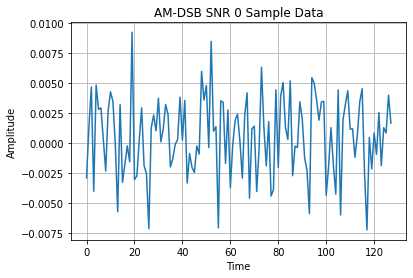

In [ ]:
plt.plot(Data[b'AM-DSB',0][2,0])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("AM-DSB SNR 0 Sample Data")
plt.grid(b=True, axis='both')

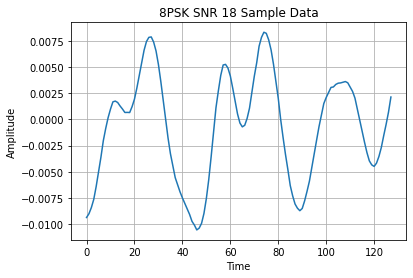

In [ ]:
plt.plot(Data[b'8PSK',18][2,0])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("8PSK SNR 18 Sample Data")
plt.grid(b=True, axis='both')

# Data Splitting And Balancing

In [6]:
#Reshaping dataset
samples = samples.reshape((samples.shape[0] * samples.shape[1], samples.shape[2], samples.shape[3]))
labels = snr_mod_labels.reshape((-1, 2)) # Notic that the labels are at this format [snr, modulation]

In [ ]:
print('samples shape:', samples.shape)
print('labels shape:', labels.shape)

samples shape: (1200000, 2, 128)
labels shape: (1200000, 2)


In [7]:
#Splitting data
training_val_data, testing_data, training_val_pair_labels, testing_pair_labels = train_test_split(samples, labels,stratify=labels, shuffle=True, test_size=0.3)
training_data, validation_data, training_pair_labels, validation_pair_labels =  train_test_split(training_val_data, training_val_pair_labels,stratify=training_val_pair_labels, shuffle=True, test_size=0.05)

In [9]:
del samples

In [8]:
training_labels = training_pair_labels[:, 1]
validation_labels = validation_pair_labels[:, 1]

In [ ]:
print('training data shape:', training_data.shape)
print('training labels shape:', training_labels.shape)
print('validation data shape:', validation_data.shape)
print('validation labels shape:', validation_labels.shape)
print('testing data shape:', testing_data.shape)
print('testing labels shape:', testing_pair_labels.shape)

training data shape: (798000, 2, 128)
training labels shape: (798000,)
validation data shape: (42000, 2, 128)
validation labels shape: (42000,)
testing data shape: (360000, 2, 128)
testing labels shape: (360000, 2)


In [49]:
unique, counts = np.unique(training_labels, return_counts=True)
print('training:\t', dict(zip(unique, counts)))
unique, counts = np.unique(validation_labels, return_counts=True)
print('validation:\t', dict(zip(unique, counts)))
unique, counts = np.unique(testing_pair_labels, return_counts=True)
print('testing:\t', dict(zip(unique, counts)))

training:	 {b'8PSK': 79800, b'AM-DSB': 79800, b'BPSK': 79800, b'CPFSK': 79800, b'GFSK': 79800, b'PAM4': 79800, b'QAM16': 79800, b'QAM64': 79800, b'QPSK': 79800, b'WBFM': 79800}
validation:	 {b'8PSK': 4200, b'AM-DSB': 4200, b'BPSK': 4200, b'CPFSK': 4200, b'GFSK': 4200, b'PAM4': 4200, b'QAM16': 4200, b'QAM64': 4200, b'QPSK': 4200, b'WBFM': 4200}
testing:	 {b'-10': 18000, b'-12': 18000, b'-14': 18000, b'-16': 18000, b'-18': 18000, b'-2': 18000, b'-20': 18000, b'-4': 18000, b'-6': 18000, b'-8': 18000, b'0': 18000, b'10': 18000, b'12': 18000, b'14': 18000, b'16': 18000, b'18': 18000, b'2': 18000, b'4': 18000, b'6': 18000, b'8': 18000, b'8PSK': 36000, b'AM-DSB': 36000, b'BPSK': 36000, b'CPFSK': 36000, b'GFSK': 36000, b'PAM4': 36000, b'QAM16': 36000, b'QAM64': 36000, b'QPSK': 36000, b'WBFM': 36000}


In [10]:
# converting labels to one hot encoding
training_onehot = OneHotEncoder(sparse = False).fit_transform(training_labels.reshape(-1,1))
validation_onehot = OneHotEncoder(sparse = False).fit_transform(validation_labels.reshape(-1,1))

In [ ]:
print('training onehot encoding shape:', training_onehot.shape)
print('validation onehot encoding shape:', validation_onehot.shape)

training onehot encoding shape: (798000, 10)
validation onehot encoding shape: (42000, 10)


# Scoring functions

In [11]:
def model_pred_and_accuracy(model, testing_data, testing_labels):
  pred = model.predict(testing_data)
  decoded_pred = np.argmax(pred, axis=1)
  testing_labels = np.argmax(testing_labels, axis=1)

  return pred, accuracy_score(testing_labels, decoded_pred)

In [12]:
def confusion_matrixf(pred, actual, title):
  actual_decode = np.argmax(actual, axis=1)
  pred_decode = np.argmax(pred, axis=1)
  confusion_mtx = confusion_matrix(actual_decode, pred_decode)
  plt.figure(figsize=(10, 8))
  sns.heatmap(confusion_mtx, xticklabels=mods, yticklabels=mods, annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Actual')
  plt.title(title)
  plt.show()

In [13]:
def plot_model_history(history, title=''):
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.title(title)
  plt.show()

In [14]:
def plot_snr_vs_acc(snr, acc):
  plt.plot(snr, acc, label = "SNR vs Accuracy")
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [51]:
import gc, torch
def clear_cache():
  for _ in range(0,100):
    gc.collect()
    torch.cuda.empty_cache()

In [50]:
clear_cache()

In [52]:
def model_scoring(model, testing_data, testing_pair_labels):
  sorted_idx = testing_pair_labels[:, 0].astype(int).argsort() # sort by snr value
  testing_data = testing_data[sorted_idx] # to sort samples by snr
  testing_pair_labels = testing_pair_labels[sorted_idx] # to sort labels by snr

  SNRs = testing_pair_labels[:, 0]
  modulations = testing_pair_labels[:, 1]
  unique_snr, snr_count = np.unique(SNRs, return_counts=True)
  snr_count_dict = dict(zip(unique, counts))
  
  curr_sample = 0
  snrArr = []
  acc = []
  for snr in range(len(unique_snr)):
    curr_snr = SNRs[curr_sample]
    curr_snr_samples = []
    curr_snr_labels = []
    for j in range(snr_count_dict[curr_snr]):
      curr_snr_samples.append(testing_data[curr_sample])
      curr_snr_labels.append(modulations[curr_sample])
      curr_sample += 1
    
    curr_snr_samples = np.array(curr_snr_samples)
    curr_snr_labels = np.array(curr_snr_labels)
    onehot_labels = OneHotEncoder(sparse = False).fit_transform(curr_snr_labels.reshape(-1,1))

    pred, accuracy = model_pred_and_accuracy(model, curr_snr_samples, onehot_labels)
    snrArr.append(curr_snr.decode())
    acc.append(accuracy)
    print('Accuracy at SNR = ' + curr_snr.decode() + ' is ' + str(accuracy) + '%')
    confusion_matrixf(pred, onehot_labels, 'SNR: ' + curr_snr.decode())
    clear_cache()
  plot_snr_vs_acc(snrArr, acc)

# Normal Feature Space

## CNN LSTM Model

In [16]:
learning_rate = 0.001
batch_size = 512
epochs = 200

In [ ]:
'''cnn_lstm_model = Sequential()
cnn_lstm_model.add(ConvLSTM2D(256, kernel_size = (3, 3), padding = 'same', activation='relu', return_sequences = True))
cnn_lstm_model.add(Dropout(0.5))
cnn_lstm_model.add(ConvLSTM2D(64, kernel_size = (3, 3), padding = 'same', activation='relu', return_sequences = True))
cnn_lstm_model.add(Dropout(0.5))
cnn_lstm_model.add(Flatten())
cnn_lstm_model.add(Dense(128, activation='relu' ))
cnn_lstm_model.add(Dense(10,  activation='softmax'))
cnn_lstm_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))'''

In [ ]:
X_trainp = np.asarray(np.transpose(training_data, axes=(0,2,1)))
X_valp   = np.asarray(np.transpose(validation_data  , axes=(0,2,1)))
n_timesteps, n_features, n_outputs = X_trainp.shape[1], X_trainp.shape[2], validation_onehot.shape[1]
n_steps, n_length = 4, 32
X_trainp = X_trainp.reshape((X_trainp.shape[0], n_steps, n_length, n_features))
X_valp = X_valp.reshape((X_valp.shape[0], n_steps, n_length, n_features))

In [ ]:
X_test = np.asarray(np.transpose(testing_data, axes=(0,2,1)))
n_timesteps, n_features, n_outputs = X_test.shape[1], X_test.shape[2], validation_onehot.shape[1]
n_steps, n_length = 4, 32
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))


In [ ]:
cnn_lstm_model_2 = Sequential()
cnn_lstm_model_2.add(TimeDistributed(Conv1D(filters=256,  padding = 'same',kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
cnn_lstm_model_2.add(TimeDistributed(Dropout(0.5)))
cnn_lstm_model_2.add(TimeDistributed(Conv1D(filters=64,  padding = 'same' ,kernel_size=3, activation='relu')))
cnn_lstm_model_2.add(TimeDistributed(Dropout(0.5)))
cnn_lstm_model_2.add(TimeDistributed(Flatten()))
cnn_lstm_model_2.add(LSTM(100))
cnn_lstm_model_2.add(Dense(128, activation='relu'))
cnn_lstm_model_2.add(Dense(n_outputs, activation='softmax'))
cnn_lstm_model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True,)
checkpointer = ModelCheckpoint(filepath='saved_models/cnn_lstm_classification.hdf5', verbose=1, save_best_only=True)

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
with tf.device('/device:GPU:0'):
  history = cnn_lstm_model_2.fit(X_trainp, training_onehot, batch_size=512, epochs=epochs, validation_data=(X_valp, validation_onehot), callbacks=[es, checkpointer], verbose=1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/200
1559/1559 [==============================] - ETA: 0s - loss: 1.5078 - accuracy: 0.3905
Epoch 1: val_loss improved from inf to 1.19245, saving model to saved_models/cnn_lstm_classification.hdf5
1559/1559 [==============================] - 92s 50ms/step - loss: 1.5078 - accuracy: 0.3905 - val_loss: 1.1925 - val_accuracy: 0.5016
Epoch 2/200
1558/1559 [============================>.] - ETA: 0s - loss: 1.1865 - accuracy: 0.5073
Epoch 2: val_loss improved from 1.19245 to 1.12965, saving model to saved_models/cnn_lstm_classification.hdf5
1559/1559 [==============================] - 80s 51ms/step - loss: 1.1865 - accuracy: 0.5073 - val_loss: 1.1297 - val_accuracy: 0.5262
Epoch 3/200
1558/1559 [============================>.] - ETA: 0s - loss: 1.1431 - accuracy: 0.5233
Epoch 3: val_loss improved from 1.12965 to 1.11247, saving model to saved_models/cnn_lstm_classification.hdf5
1559/1559 [==============================] - 79s 50ms/step - loss: 1.1430 - accuracy: 0.5234 - val_loss: 1.

In [ ]:
'''with tf.device('/device:GPU:0'):
  history = cnn_lstm_model.fit(training_data, training_onehot, batch_size=512, epochs=1, validation_data=(validation_data, validation_onehot), callbacks=[es, checkpointer], verbose=1)'''

"with tf.device('/device:GPU:0'):\n  history = cnn_lstm_model.fit(training_data, training_onehot, batch_size=512, epochs=1, validation_data=(validation_data, validation_onehot), callbacks=[es, checkpointer], verbose=1)"

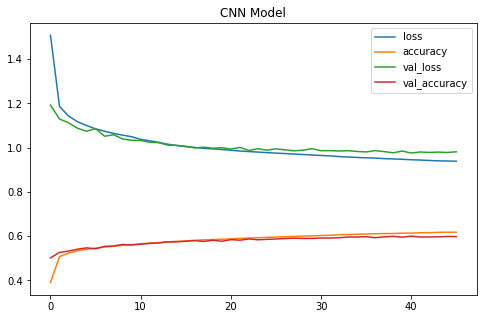

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -20 is 0.11244444444444444%


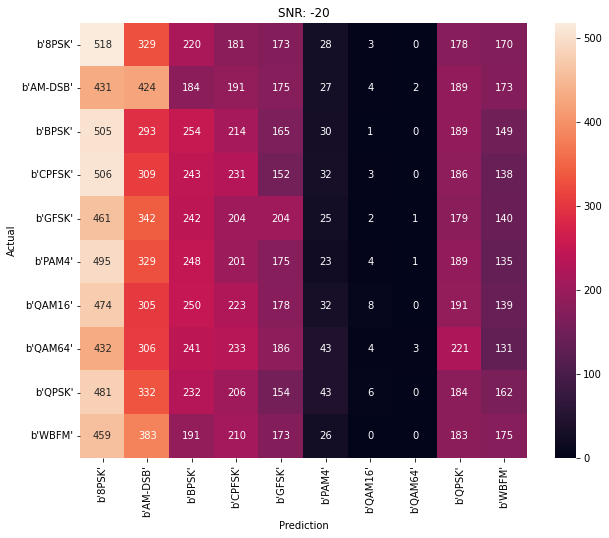

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -18 is 0.11088888888888888%


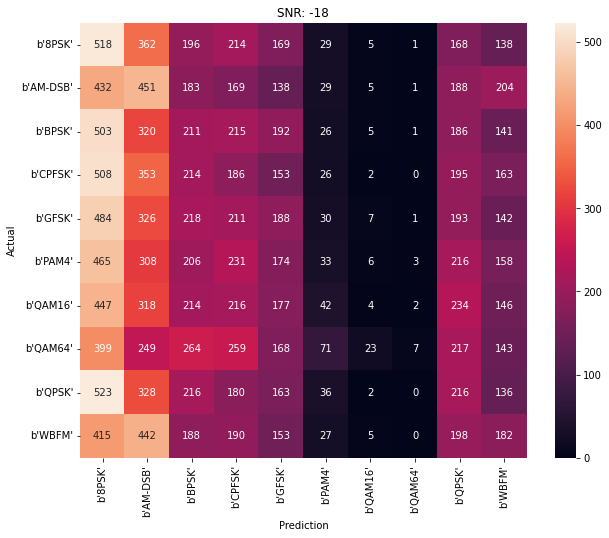

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -16 is 0.125%


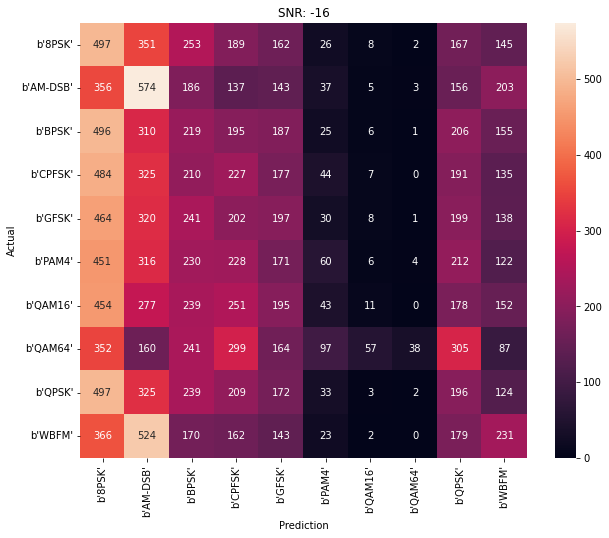

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -14 is 0.14522222222222222%


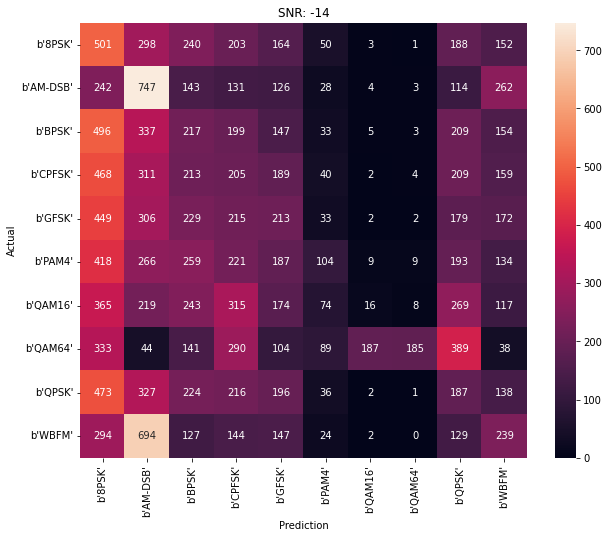

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -12 is 0.19672222222222221%


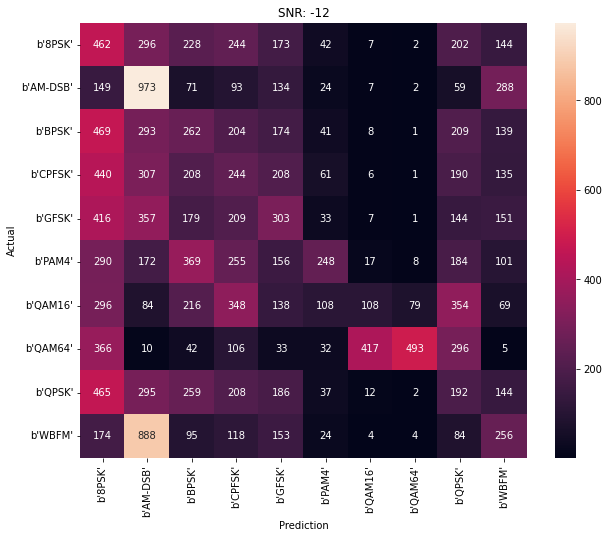

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -10 is 0.28005555555555556%


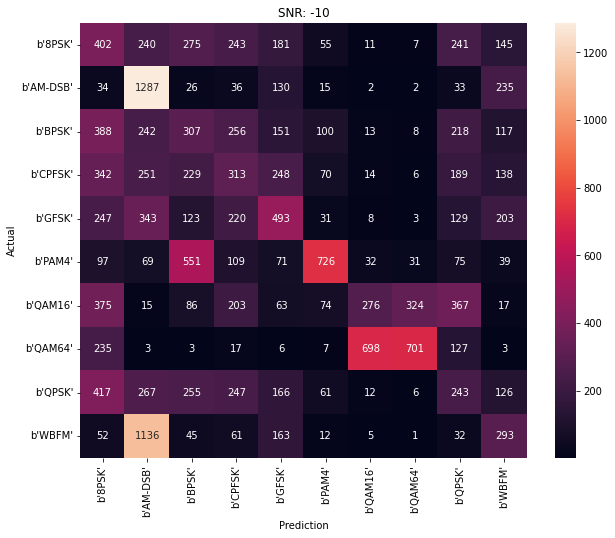

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -8 is 0.386%


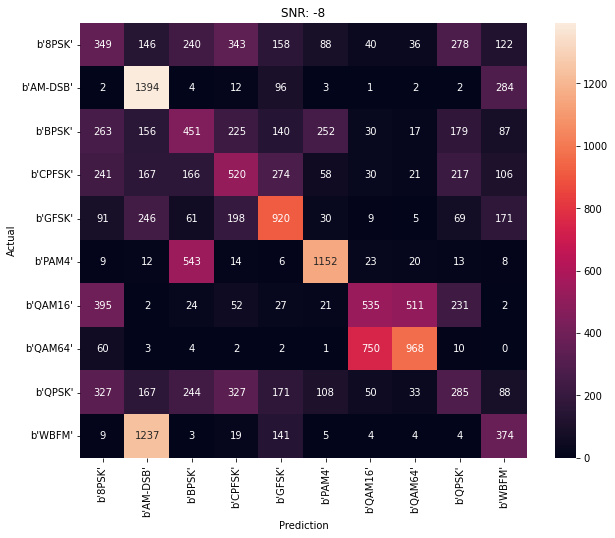

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -6 is 0.5236111111111111%


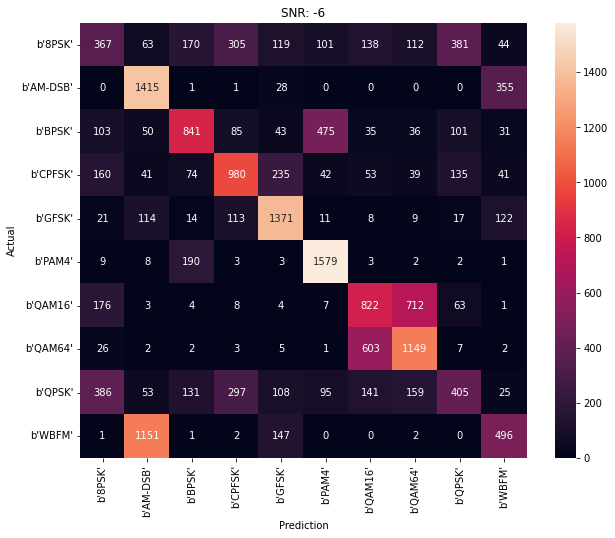

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -4 is 0.6671666666666667%


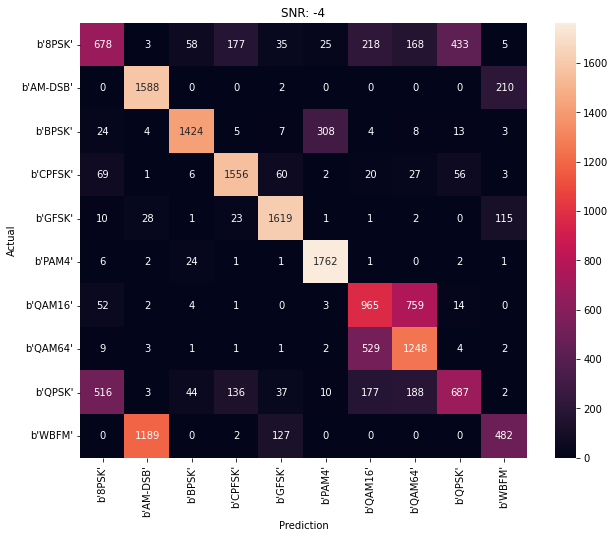

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -2 is 0.771%


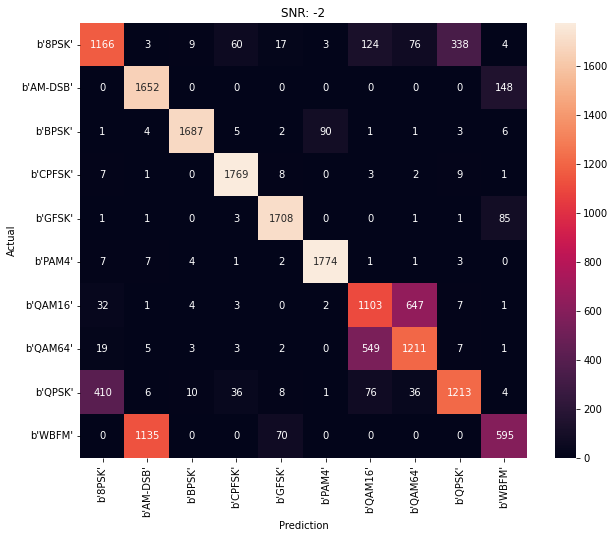

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 0 is 0.8397222222222223%


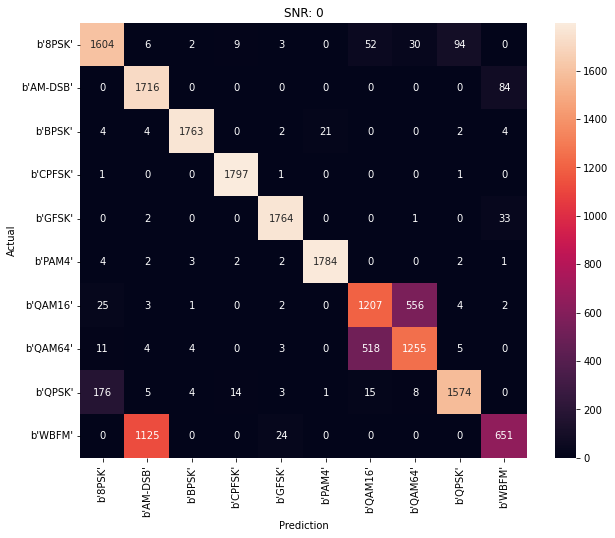

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 2 is 0.8636666666666667%


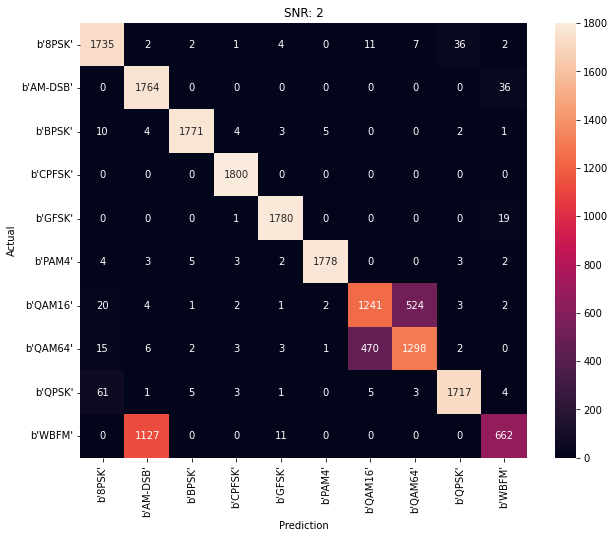

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 4 is 0.8733333333333333%


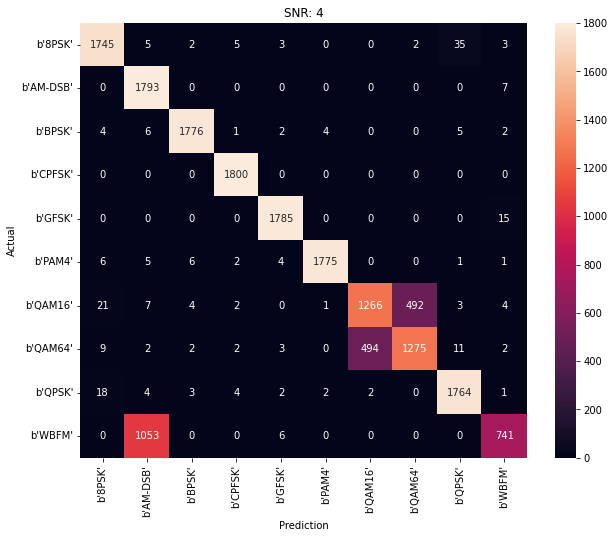

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 6 is 0.8771111111111111%


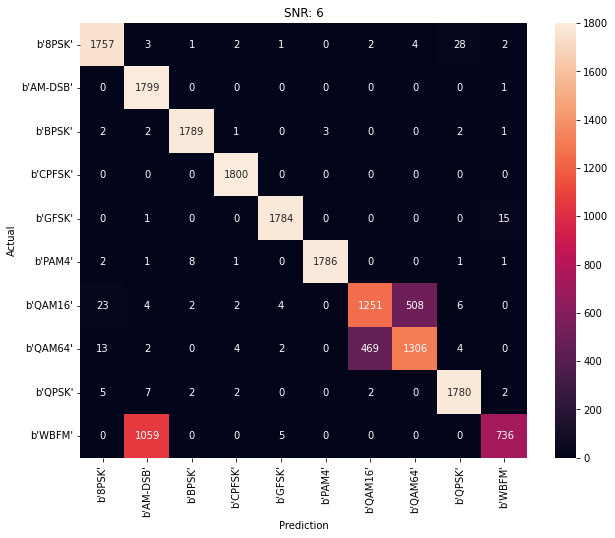

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 8 is 0.8787777777777778%


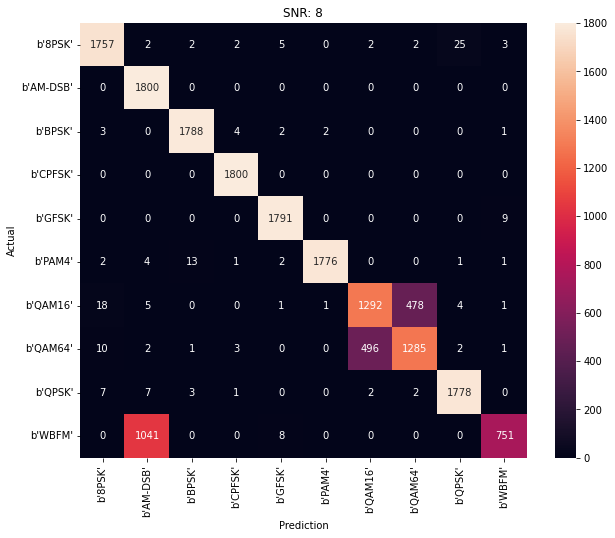

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 10 is 0.8761111111111111%


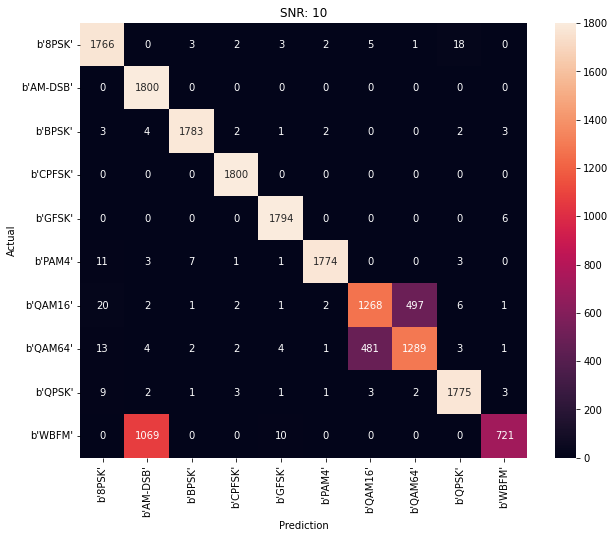

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 12 is 0.8747222222222222%


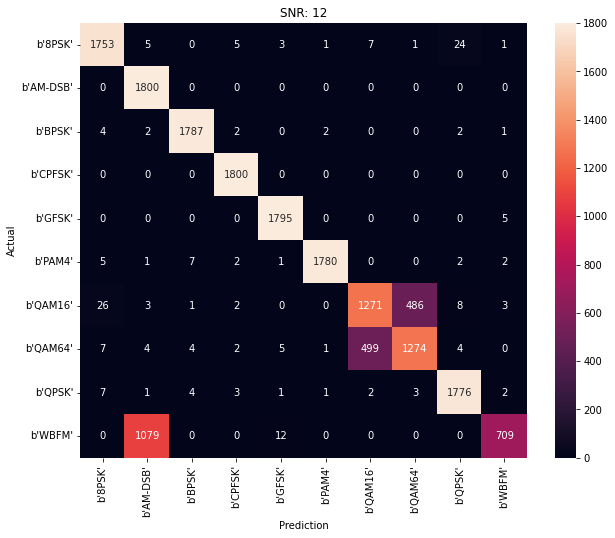

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 14 is 0.8766111111111111%


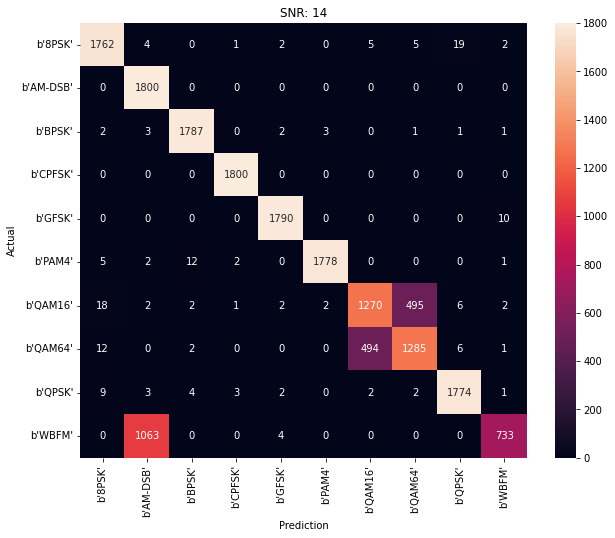

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 16 is 0.8773888888888889%


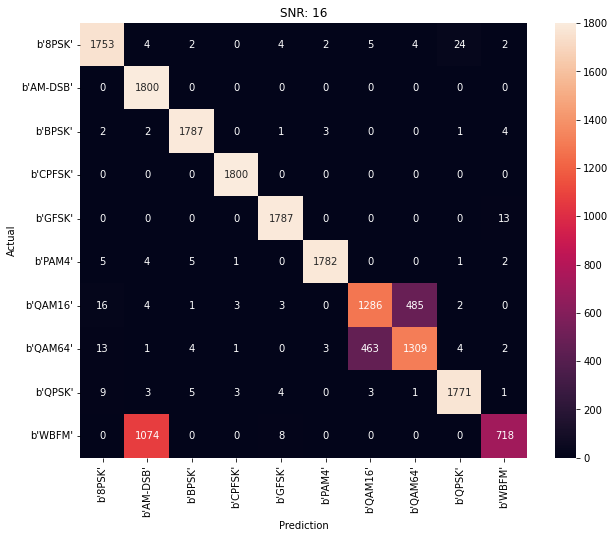

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 18 is 0.8781111111111111%


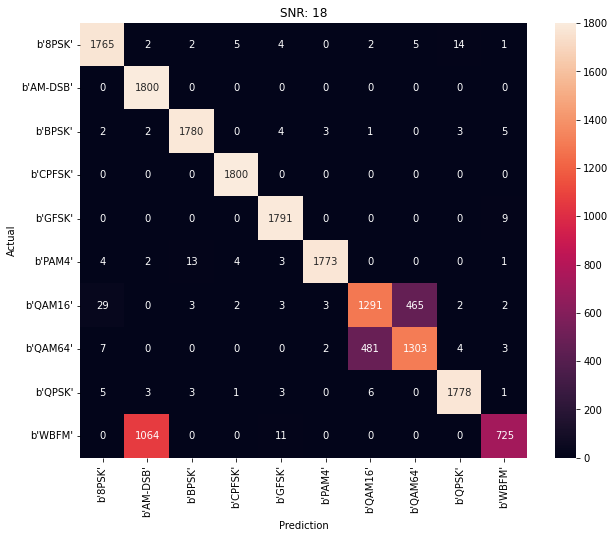

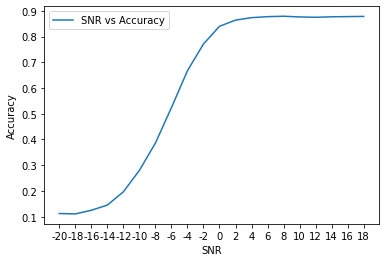

In [ ]:
plot_model_history(history, 'CNN Model')
model_scoring(cnn_lstm_model_2, X_test, testing_pair_labels)  

# Differentiated Features Space

In [17]:
fdit_training_data = np.concatenate((normalize(np.gradient(training_data[:,0], axis = 1)), normalize(np.gradient(training_data[:,1], axis = 1))), axis=1).reshape(training_data.shape)
fdit_validation_data = np.concatenate((normalize(np.gradient(validation_data[:,0], axis = 1)), normalize(np.gradient(validation_data[:,1], axis = 1))), axis=1).reshape(validation_data.shape)
fdit_testing_data = np.concatenate((normalize(np.gradient(testing_data[:,0], axis = 1)), normalize(np.gradient(testing_data[:,1], axis = 1))), axis=1).reshape(testing_data.shape)


In [ ]:
print('fdit training data shape:', fdit_training_data.shape)
print('fdit validation data shape:', fdit_validation_data.shape)
print('fdit testing data shape:', fdit_testing_data.shape)

fdit training data shape: (798000, 2, 128)
fdit validation data shape: (42000, 2, 128)
fdit testing data shape: (360000, 2, 128)


In [ ]:
X_trainp = np.asarray(np.transpose(fdit_training_data, axes=(0,2,1)))
X_valp   = np.asarray(np.transpose(fdit_validation_data  , axes=(0,2,1)))
n_timesteps, n_features, n_outputs = X_trainp.shape[1], X_trainp.shape[2], validation_onehot.shape[1]
n_steps, n_length = 4, 32
X_trainp = X_trainp.reshape((X_trainp.shape[0], n_steps, n_length, n_features))
X_valp = X_valp.reshape((X_valp.shape[0], n_steps, n_length, n_features))

In [ ]:
X_test = np.asarray(np.transpose(fdit_testing_data, axes=(0,2,1)))
n_timesteps, n_features, n_outputs = X_test.shape[1], X_test.shape[2], validation_onehot.shape[1]
n_steps, n_length = 4, 32
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True,)
checkpointer = ModelCheckpoint(filepath='saved_models/cnn_lstm_classification.hdf5', verbose=1, save_best_only=True)

In [ ]:
cnn_lstm_model_2 = Sequential()
cnn_lstm_model_2.add(TimeDistributed(Conv1D(filters=256,  padding = 'same',kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
cnn_lstm_model_2.add(TimeDistributed(Dropout(0.5)))
cnn_lstm_model_2.add(TimeDistributed(Conv1D(filters=64,  padding = 'same' ,kernel_size=3, activation='relu')))
cnn_lstm_model_2.add(TimeDistributed(Dropout(0.5)))
cnn_lstm_model_2.add(TimeDistributed(Flatten()))
cnn_lstm_model_2.add(LSTM(100))
cnn_lstm_model_2.add(Dense(128, activation='relu'))
cnn_lstm_model_2.add(Dense(n_outputs, activation='softmax'))
cnn_lstm_model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [ ]:
with tf.device('/device:GPU:0'):
  history = cnn_lstm_model_2.fit(X_trainp, training_onehot, batch_size=512, epochs=epochs, validation_data=(X_valp, validation_onehot), callbacks=[es, checkpointer], verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/200
1558/1559 [============================>.] - ETA: 0s - loss: 1.7376 - accuracy: 0.3233
Epoch 1: val_loss did not improve from 0.97569
1559/1559 [==============================] - 78s 50ms/step - loss: 1.7375 - accuracy: 0.3233 - val_loss: 1.5296 - val_accuracy: 0.4062
Epoch 2/200
1558/1559 [============================>.] - ETA: 0s - loss: 1.5176 - accuracy: 0.4066
Epoch 2: val_loss did not improve from 0.97569
1559/1559 [==============================] - 78s 50ms/step - loss: 1.5176 - accuracy: 0.4066 - val_loss: 1.4637 - val_accuracy: 0.4289
Epoch 3/200
1558/1559 [============================>.] - ETA: 0s - loss: 1.4754 - accuracy: 0.4234
Epoch 3: val_loss did not improve from 0.97569
1559/1559 [==============================] - 78s 50ms/step - loss: 1.4753 - accuracy: 0.4234 - val_loss: 1.4435 - val_accuracy: 0.4363
Epoch 4/200
1558/1559 [============================>.] - ETA: 0s - loss: 1.4506 - accuracy: 0.4332
Epoch 4: val_loss did not improve from 0.97569
1559/1559 [

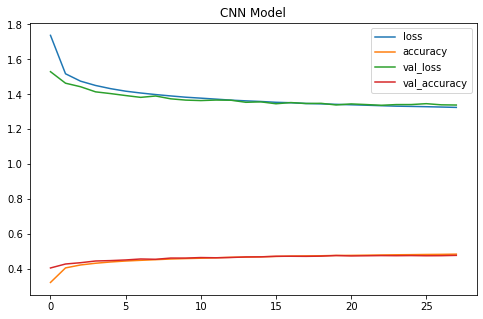

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -20 is 0.1%


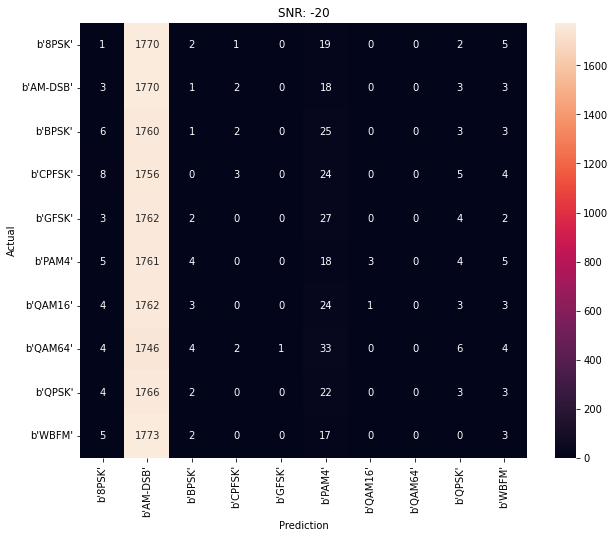

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -18 is 0.09977777777777778%


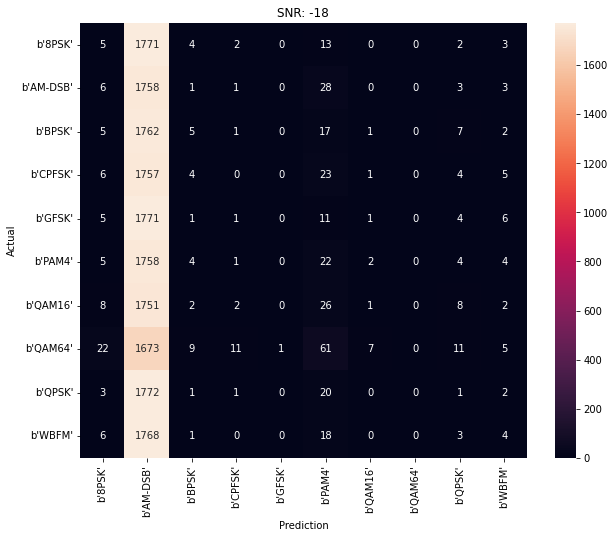

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -16 is 0.10138888888888889%


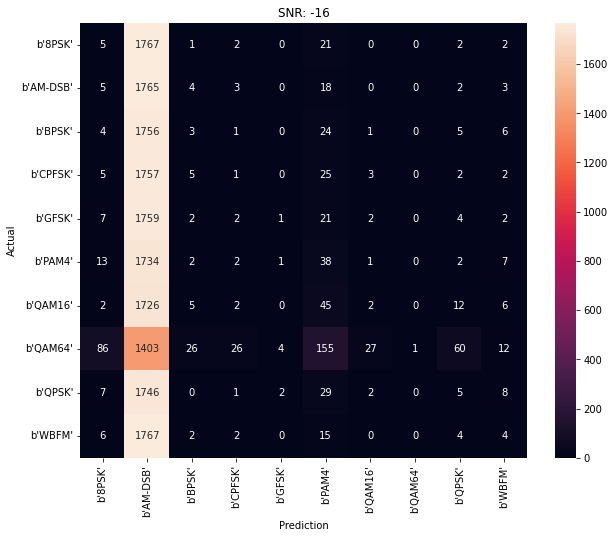

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -14 is 0.10644444444444444%


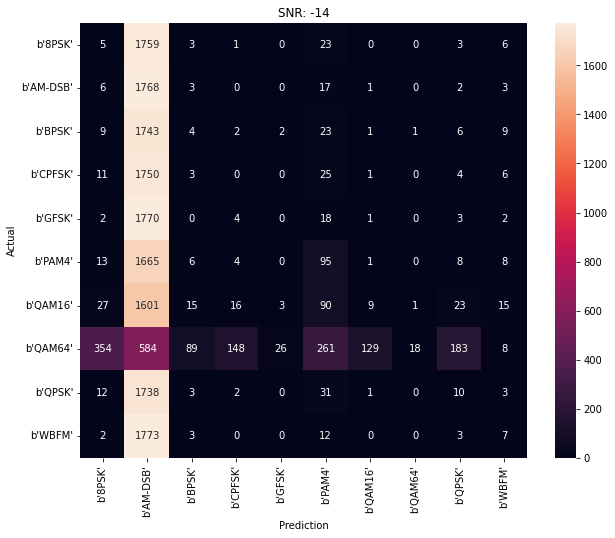

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -12 is 0.11733333333333333%


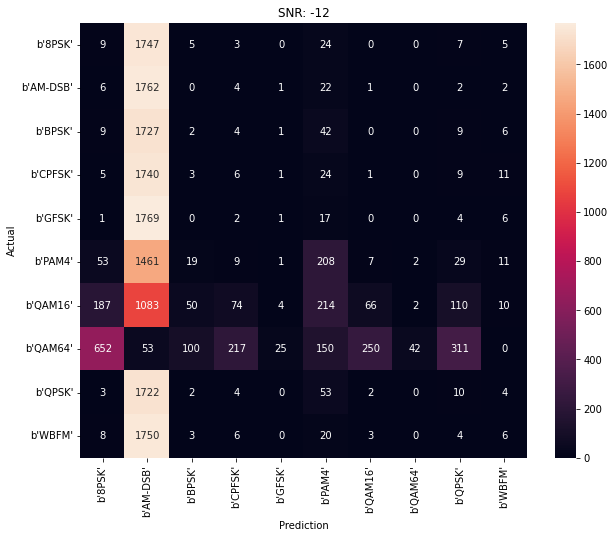

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -10 is 0.1582222222222222%


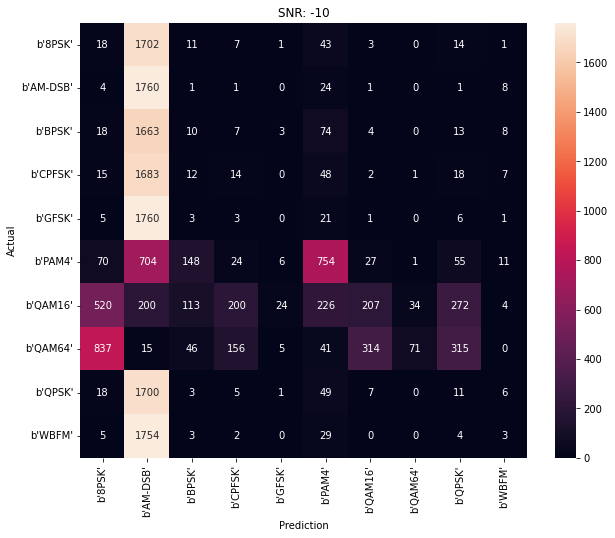

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -8 is 0.19605555555555557%


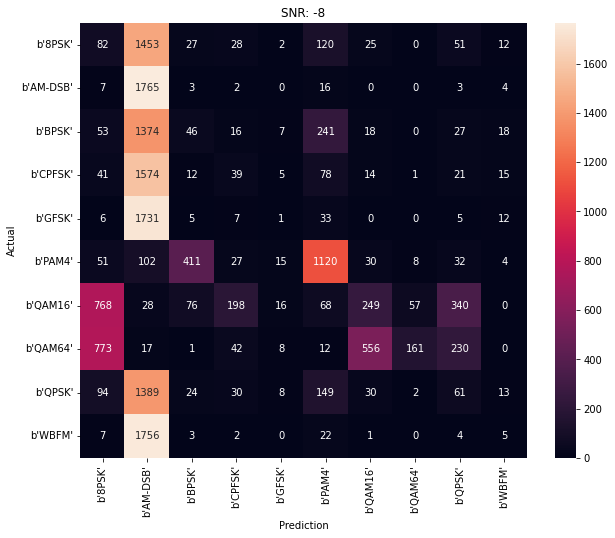

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -6 is 0.2596111111111111%


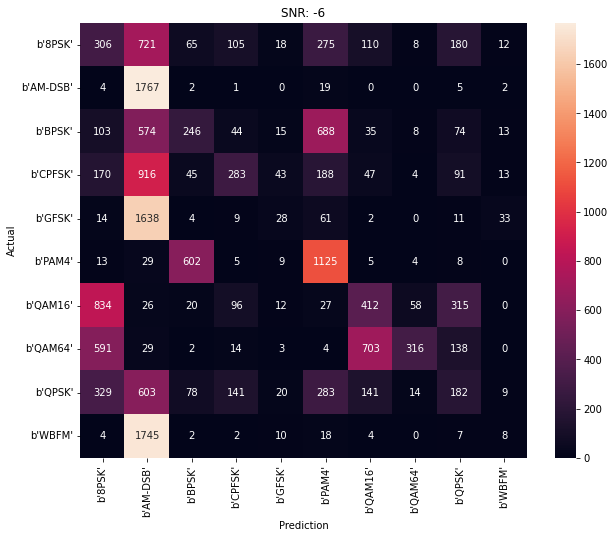

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -4 is 0.41055555555555556%


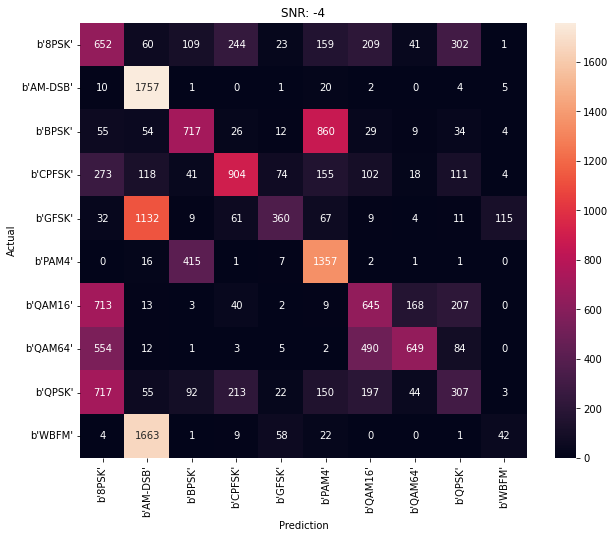

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -2 is 0.5466111111111112%


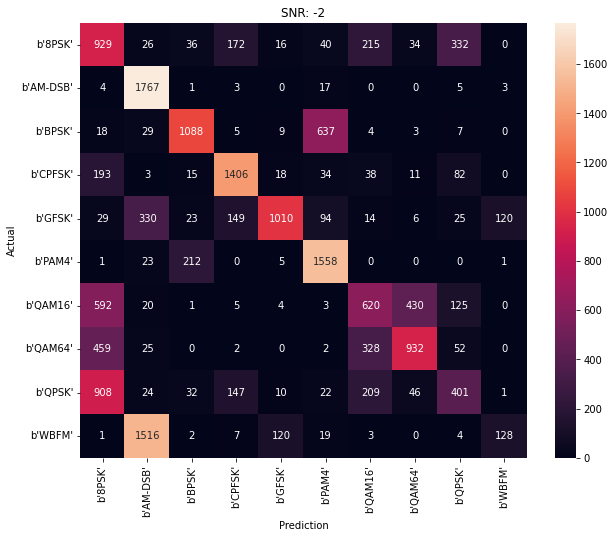

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 0 is 0.6377222222222222%


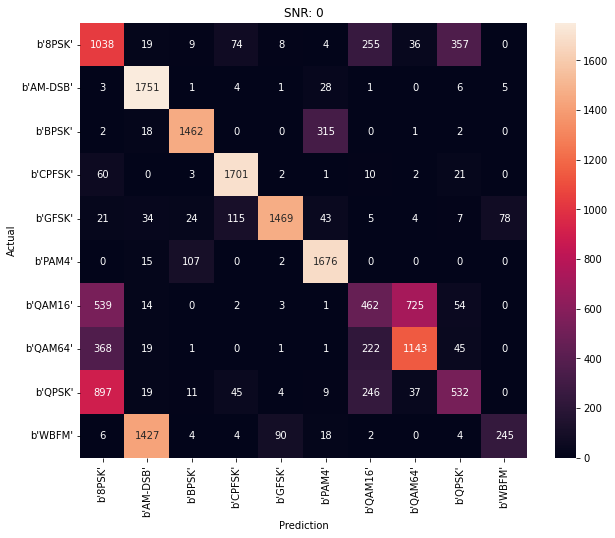

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 2 is 0.6908888888888889%


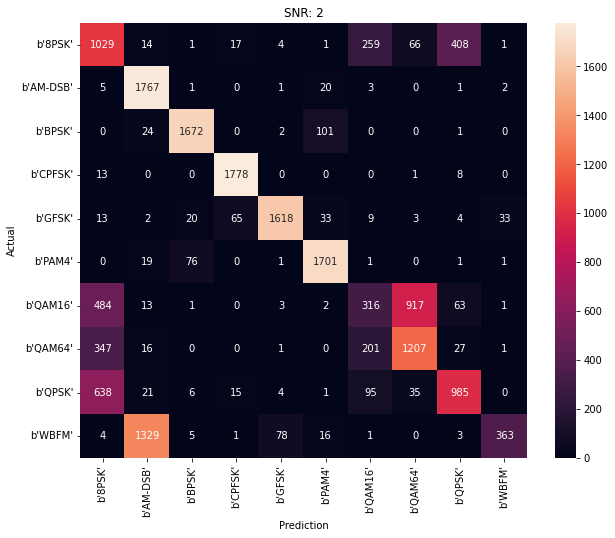

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 4 is 0.7485%


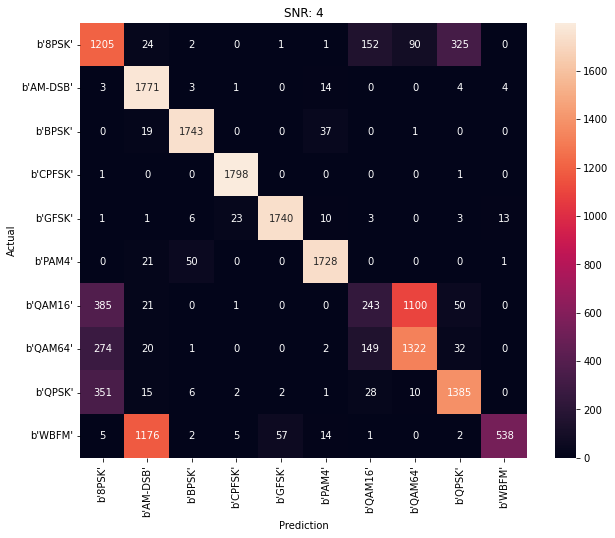

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 6 is 0.7746666666666666%


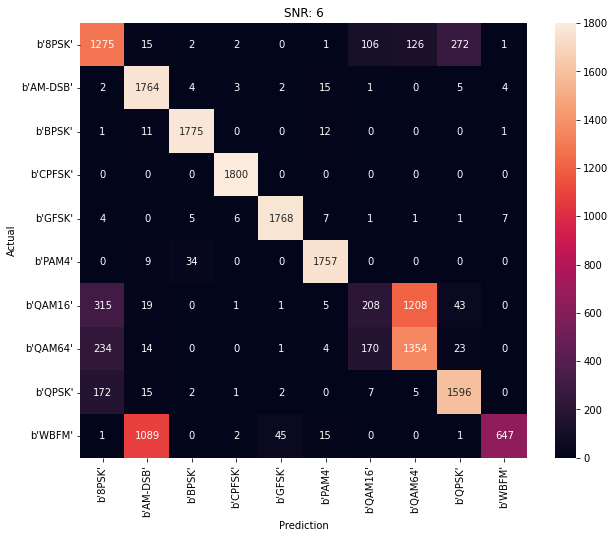

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 8 is 0.7815%


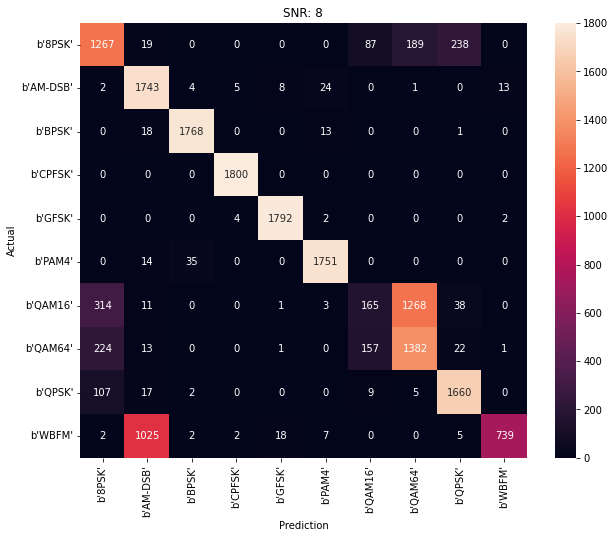

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 10 is 0.7796666666666666%


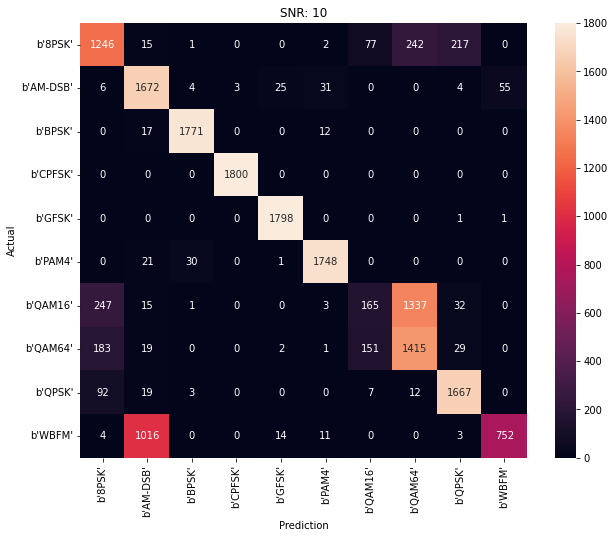

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 12 is 0.7732777777777777%


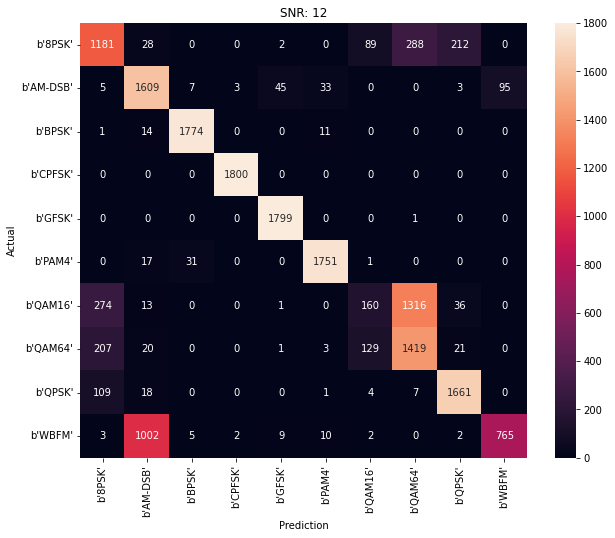

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 14 is 0.7670555555555556%


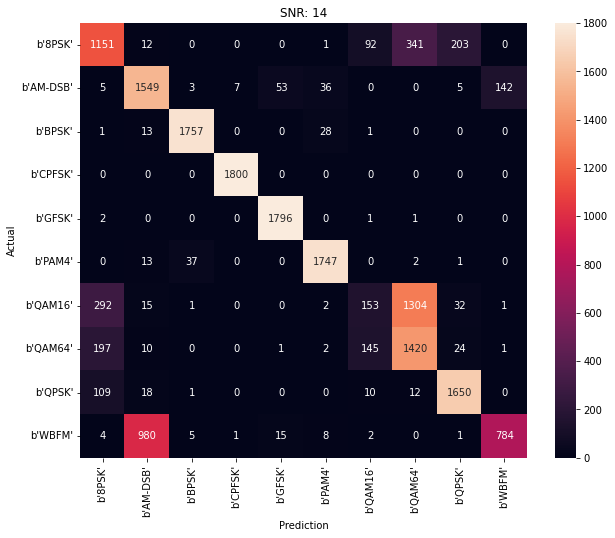

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 16 is 0.7645%


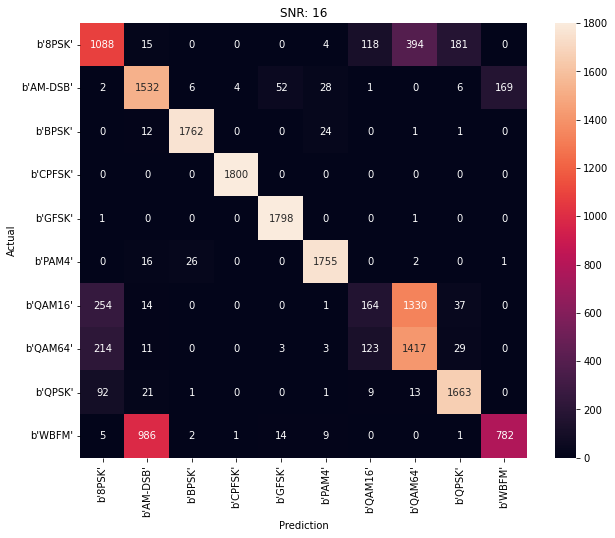

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 18 is 0.7601111111111111%


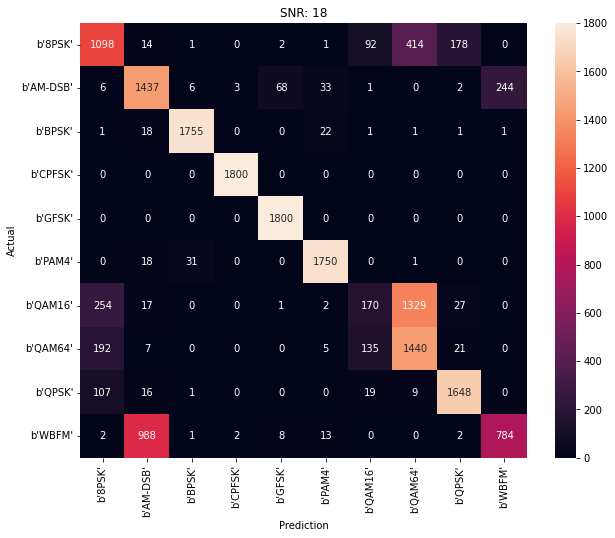

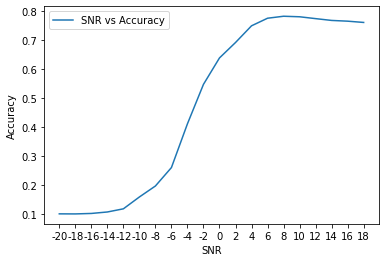

In [ ]:
plot_model_history(history, 'CNN Model')
model_scoring(cnn_lstm_model_2, X_test, testing_pair_labels)  

# Integrated Features Space

In [18]:
fiit_training_data = integrate.cumtrapz(training_data, initial=0)
fiit_validation_data = integrate.cumtrapz(validation_data, initial=0)
fiit_testing_data = integrate.cumtrapz(testing_data, initial=0)

In [ ]:
print('fiit training data shape:', fiit_training_data.shape)
print('fiit validation data shape:', fiit_validation_data.shape)
print('fiit testing data shape:', fiit_testing_data.shape)

fiit training data shape: (798000, 2, 128)
fiit validation data shape: (42000, 2, 128)
fiit testing data shape: (360000, 2, 128)


In [ ]:
X_trainp = np.asarray(np.transpose(fiit_training_data, axes=(0,2,1)))
X_valp   = np.asarray(np.transpose(fiit_validation_data  , axes=(0,2,1)))
n_timesteps, n_features, n_outputs = X_trainp.shape[1], X_trainp.shape[2], validation_onehot.shape[1]
n_steps, n_length = 4, 32
X_trainp = X_trainp.reshape((X_trainp.shape[0], n_steps, n_length, n_features))
X_valp = X_valp.reshape((X_valp.shape[0], n_steps, n_length, n_features))

In [ ]:
X_test = np.asarray(np.transpose(fiit_testing_data, axes=(0,2,1)))
n_timesteps, n_features, n_outputs = X_test.shape[1], X_test.shape[2], validation_onehot.shape[1]
n_steps, n_length = 4, 32
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))

In [ ]:
with tf.device('/device:GPU:0'):
  history = cnn_lstm_model_2.fit(X_trainp, training_onehot, batch_size=512, epochs=epochs, validation_data=(X_valp, validation_onehot), callbacks=[es, checkpointer], verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/200
1558/1559 [============================>.] - ETA: 0s - loss: 1.7231 - accuracy: 0.3158
Epoch 1: val_loss did not improve from 0.97569
1559/1559 [==============================] - 77s 50ms/step - loss: 1.7230 - accuracy: 0.3158 - val_loss: 1.5369 - val_accuracy: 0.3700
Epoch 2/200
1558/1559 [============================>.] - ETA: 0s - loss: 1.5094 - accuracy: 0.3792
Epoch 2: val_loss did not improve from 0.97569
1559/1559 [==============================] - 77s 49ms/step - loss: 1.5094 - accuracy: 0.3792 - val_loss: 1.4394 - val_accuracy: 0.4029
Epoch 3/200
1558/1559 [============================>.] - ETA: 0s - loss: 1.4548 - accuracy: 0.3997
Epoch 3: val_loss did not improve from 0.97569
1559/1559 [==============================] - 78s 50ms/step - loss: 1.4548 - accuracy: 0.3997 - val_loss: 1.4220 - val_accuracy: 0.4115
Epoch 4/200
1558/1559 [============================>.] - ETA: 0s - loss: 1.4206 - accuracy: 0.4126
Epoch 4: val_loss did not improve from 0.97569
1559/1559 [

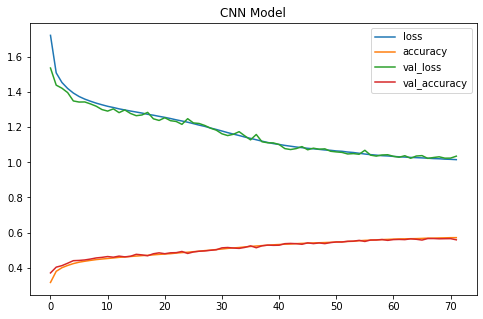

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -20 is 0.10922222222222222%


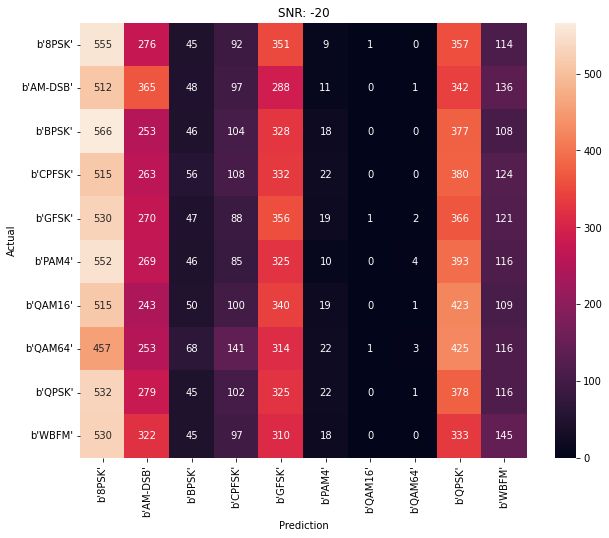

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -18 is 0.112%


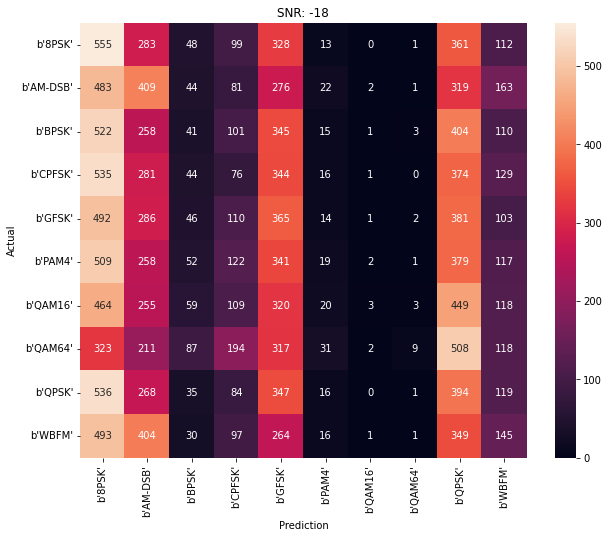

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -16 is 0.1228888888888889%


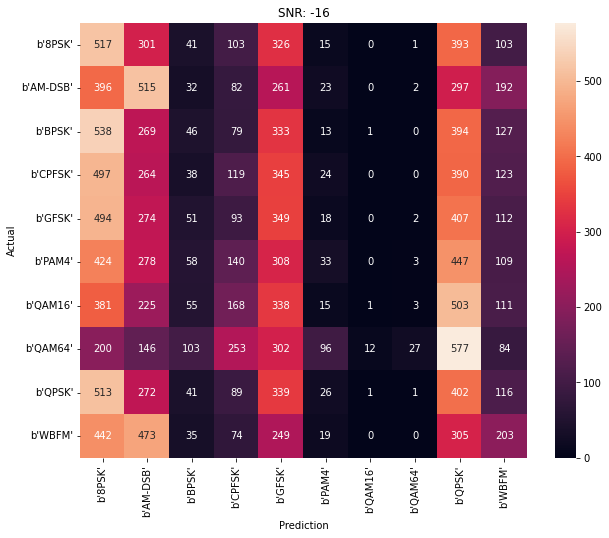

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -14 is 0.14733333333333334%


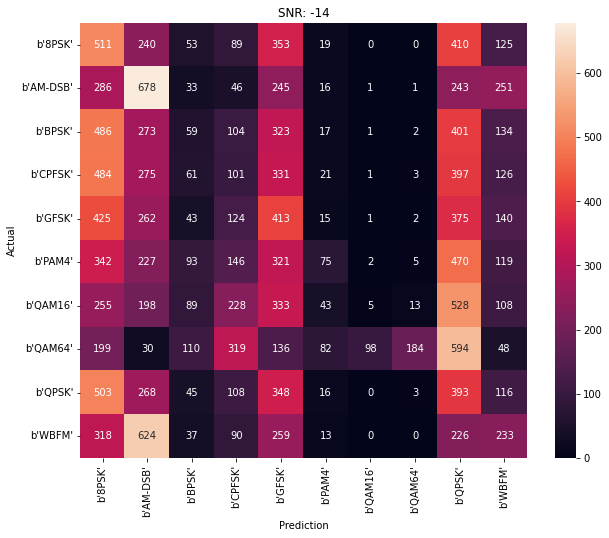

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -12 is 0.18122222222222223%


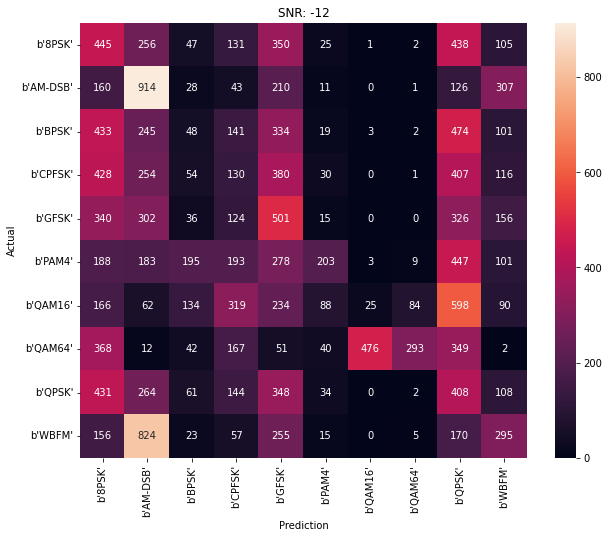

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -10 is 0.2765%


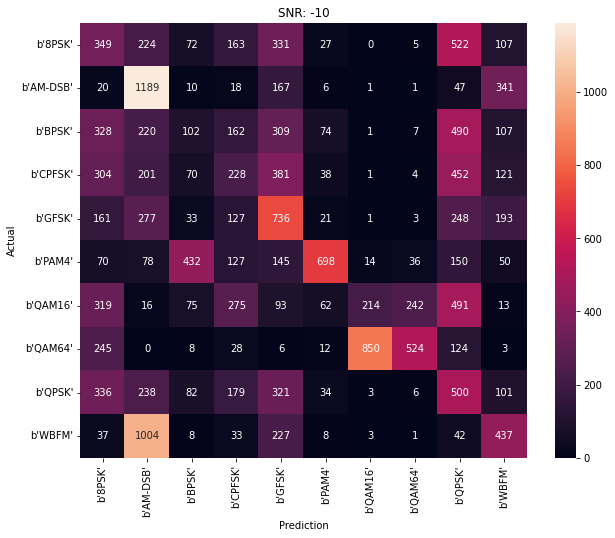

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -8 is 0.39005555555555554%


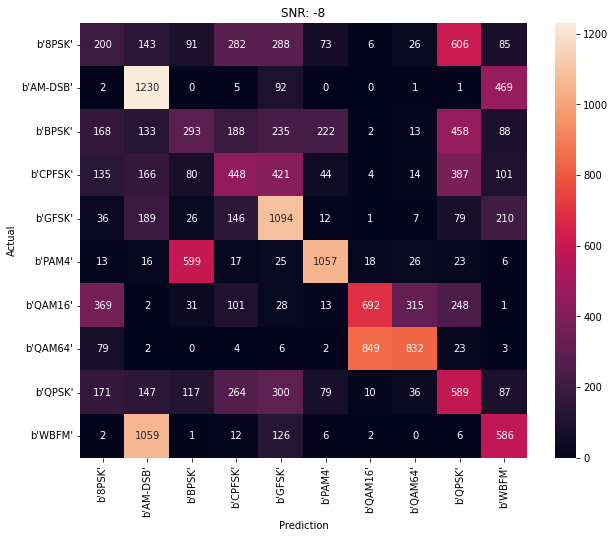

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -6 is 0.5256666666666666%


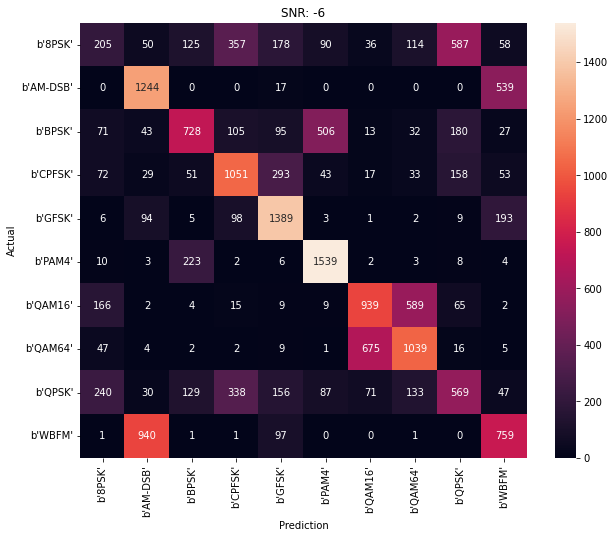

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -4 is 0.6503333333333333%


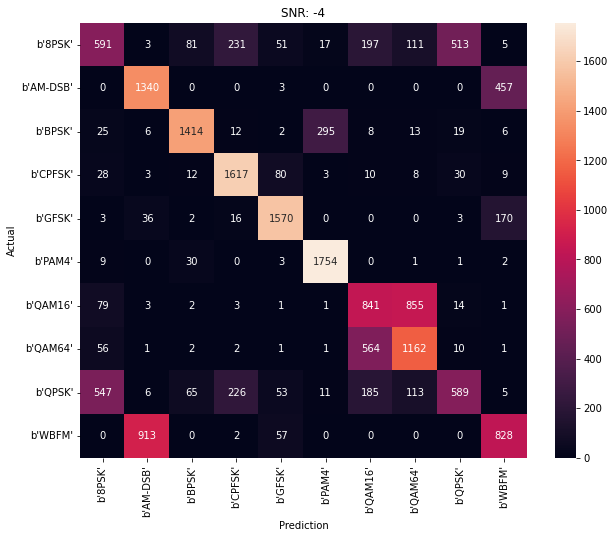

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = -2 is 0.7281111111111112%


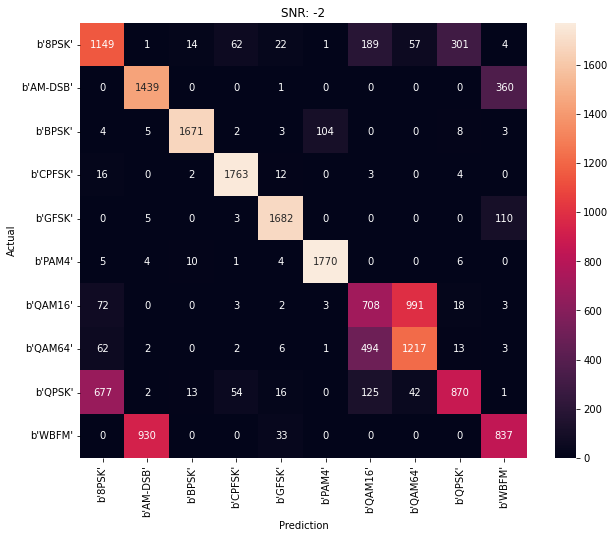

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 0 is 0.7816111111111111%


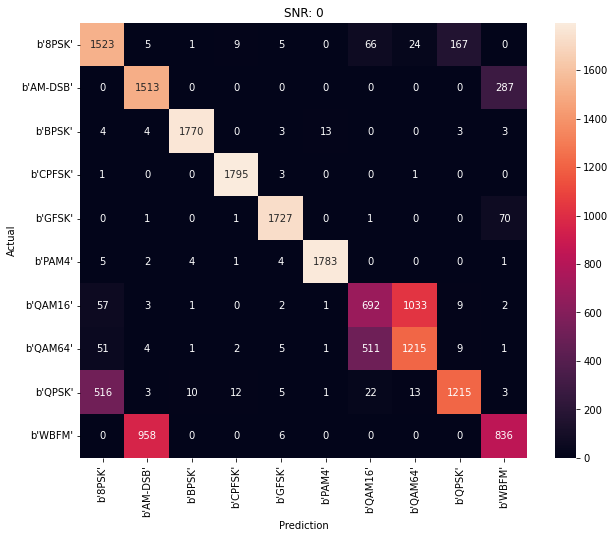

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 2 is 0.7986666666666666%


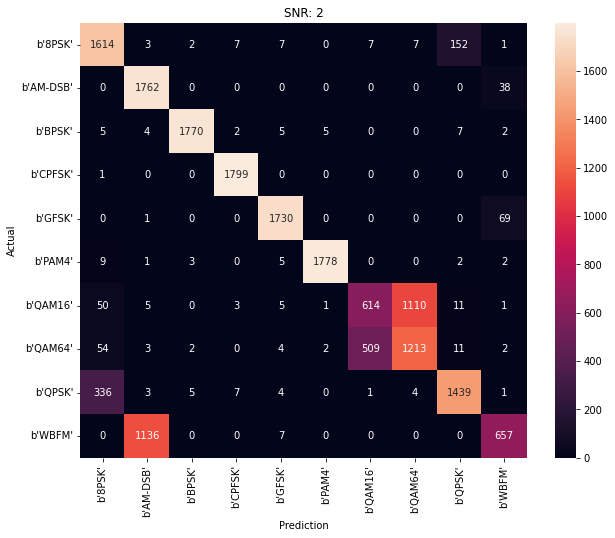

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 4 is 0.8072222222222222%


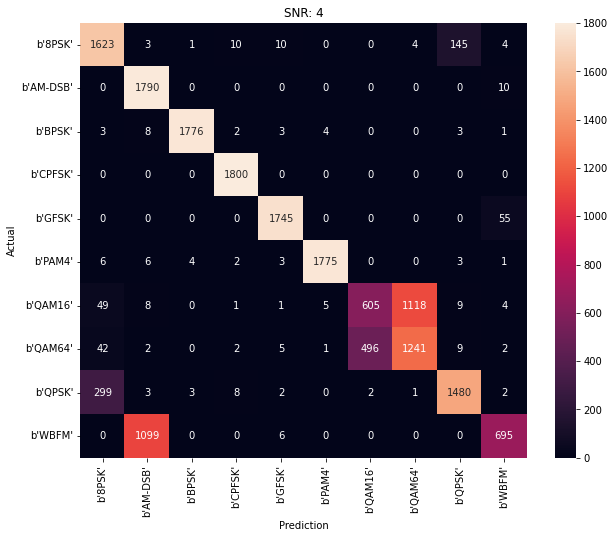

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 6 is 0.8147222222222222%


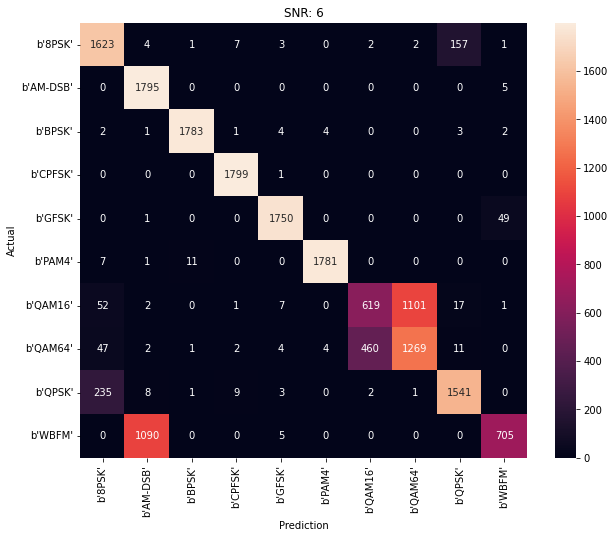

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 8 is 0.8159444444444445%


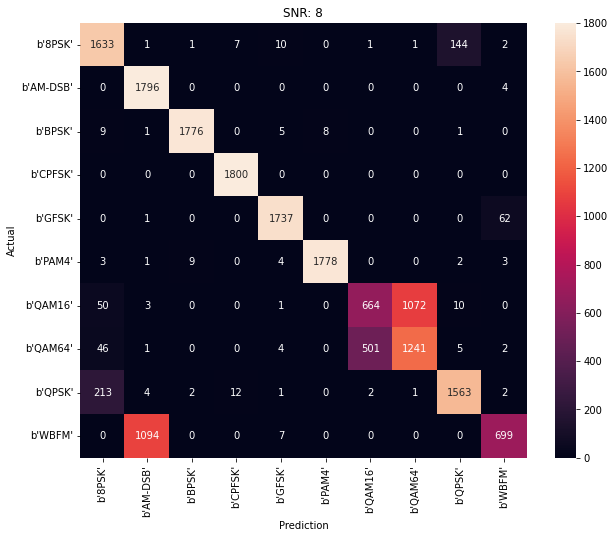

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 10 is 0.8148333333333333%


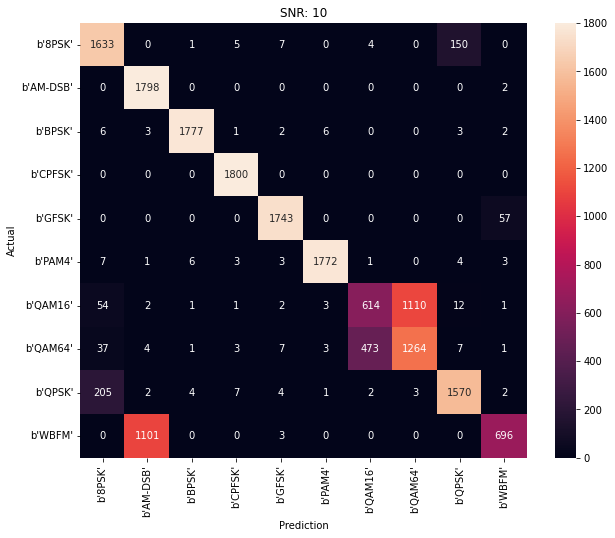

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 12 is 0.8107777777777778%


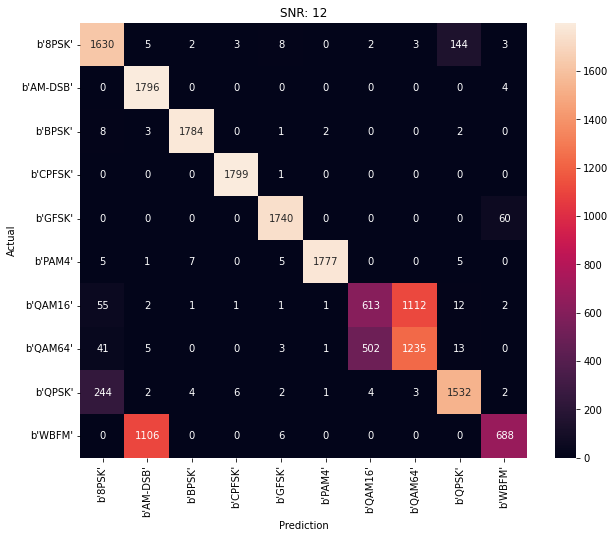

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 14 is 0.8157222222222222%


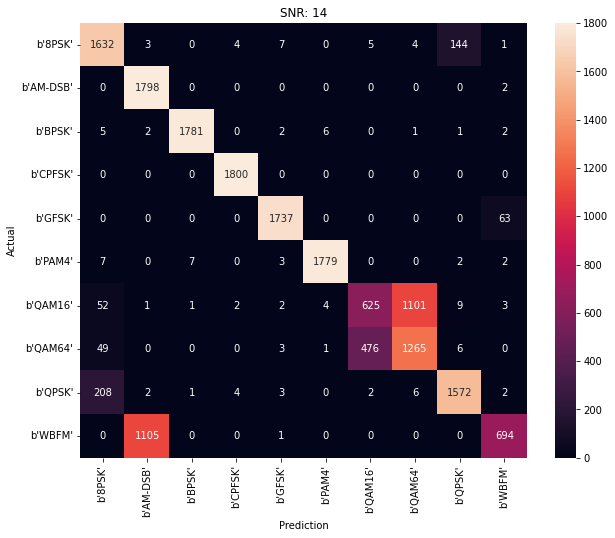

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 16 is 0.8141111111111111%


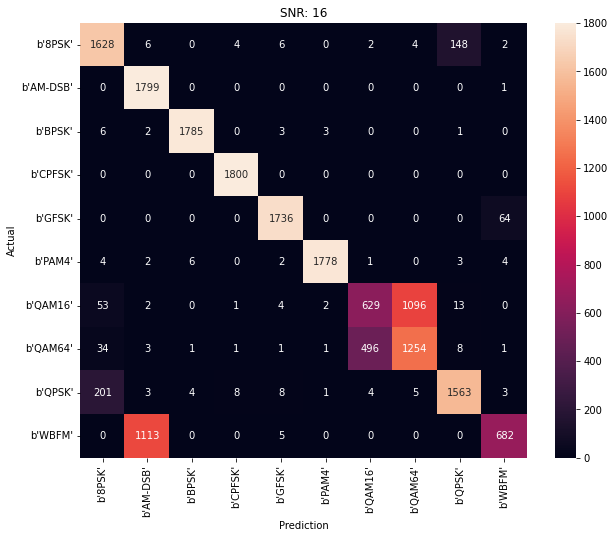

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy at SNR = 18 is 0.8138888888888889%


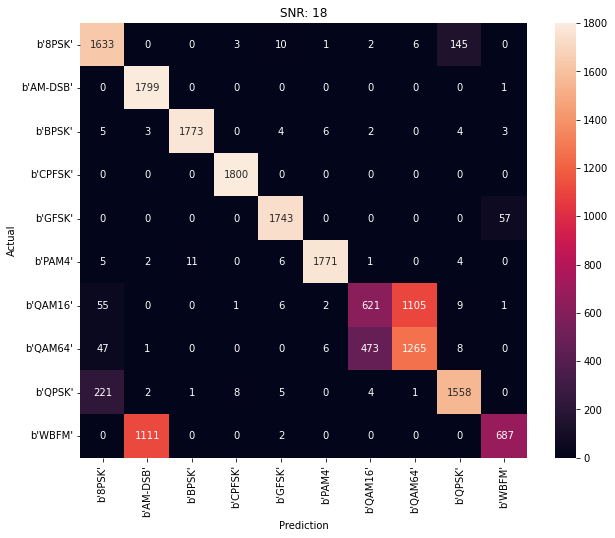

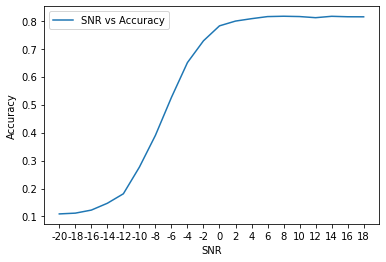

In [ ]:
plot_model_history(history, 'CNN Model')
model_scoring(cnn_lstm_model_2, X_test, testing_pair_labels)  

## CNN Model

# Combined Feature Space

In [19]:
Combined_training_data = np.concatenate((training_data ,fdit_training_data, fiit_training_data), axis=2)
Combined_validation_data = np.concatenate((validation_data ,fdit_validation_data, fiit_validation_data), axis=2)
Combined_testing_data = np.concatenate((testing_data ,fdit_testing_data, fiit_testing_data), axis=2)

In [20]:
print('combined training data shape:', Combined_training_data.shape)
print('combined validation data shape:',Combined_validation_data.shape)
print('combined testing data shape:', Combined_testing_data.shape)

combined training data shape: (798000, 2, 384)
combined validation data shape: (42000, 2, 384)
combined testing data shape: (360000, 2, 384)


In [21]:
del training_data
del fdit_training_data
del fiit_training_data

del validation_data
del fdit_validation_data
del fiit_validation_data

del testing_data
del fdit_testing_data
del fiit_testing_data

In [22]:
X_trainp = np.asarray(np.transpose(Combined_training_data, axes=(0,2,1)))
X_valp   = np.asarray(np.transpose(Combined_validation_data  , axes=(0,2,1)))
n_timesteps, n_features, n_outputs = X_trainp.shape[1], X_trainp.shape[2], validation_onehot.shape[1]
n_steps, n_length = 4, 32


In [44]:
import gc, torch
for _ in range(0,300):
  gc.collect()
  torch.cuda.empty_cache()

In [ ]:
print(X_trainp.shape)


(798000, 384, 2)


In [23]:
X_trainp = X_trainp.reshape((X_trainp.shape[0], n_steps, n_length, n_features*3))
print(X_trainp.shape)


(798000, 4, 32, 6)


In [25]:
del Combined_training_data

In [27]:
X_valp = X_valp.reshape((X_valp.shape[0], n_steps, n_length, n_features*3))

In [28]:
del Combined_validation_data

In [33]:
X_test = np.asarray(np.transpose(Combined_testing_data, axes=(0,2,1)))
n_timesteps, n_features, n_outputs = X_test.shape[1], X_test.shape[2], validation_onehot.shape[1]
n_steps, n_length = 4, 32
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features*3))

In [34]:
del Combined_testing_data

In [36]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True,)
checkpointer = ModelCheckpoint(filepath='saved_models/cnn_lstm_classification.hdf5', verbose=1, save_best_only=True)

In [37]:
cnn_lstm_model_2 = Sequential()
cnn_lstm_model_2.add(TimeDistributed(Conv1D(filters=256,  padding = 'same',kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features*3)))
cnn_lstm_model_2.add(TimeDistributed(Dropout(0.5)))
cnn_lstm_model_2.add(TimeDistributed(Conv1D(filters=64,  padding = 'same' ,kernel_size=3, activation='relu')))
cnn_lstm_model_2.add(TimeDistributed(Dropout(0.5)))
cnn_lstm_model_2.add(TimeDistributed(Flatten()))
cnn_lstm_model_2.add(LSTM(100))
cnn_lstm_model_2.add(Dense(128, activation='relu'))
cnn_lstm_model_2.add(Dense(n_outputs, activation='softmax'))
cnn_lstm_model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [38]:
with tf.device('/device:GPU:0'):
  history = cnn_lstm_model_2.fit(X_trainp, training_onehot, batch_size=512, epochs=epochs, validation_data=(X_valp, validation_onehot), callbacks=[es, checkpointer], verbose=1)

Epoch 1/200
1559/1559 [==============================] - ETA: 0s - loss: 1.4985 - accuracy: 0.3643
Epoch 1: val_loss improved from inf to 1.35977, saving model to saved_models/cnn_lstm_classification.hdf5
1559/1559 [==============================] - 66s 33ms/step - loss: 1.4985 - accuracy: 0.3643 - val_loss: 1.3598 - val_accuracy: 0.4056
Epoch 2/200
1559/1559 [==============================] - ETA: 0s - loss: 1.2907 - accuracy: 0.4437
Epoch 2: val_loss improved from 1.35977 to 1.15379, saving model to saved_models/cnn_lstm_classification.hdf5
1559/1559 [==============================] - 49s 31ms/step - loss: 1.2907 - accuracy: 0.4437 - val_loss: 1.1538 - val_accuracy: 0.5043
Epoch 3/200
1559/1559 [==============================] - ETA: 0s - loss: 1.1613 - accuracy: 0.4983
Epoch 3: val_loss improved from 1.15379 to 1.12273, saving model to saved_models/cnn_lstm_classification.hdf5
1559/1559 [==============================] - 49s 32ms/step - loss: 1.1613 - accuracy: 0.4983 - val_loss: 1.

In [47]:
clear_cache()

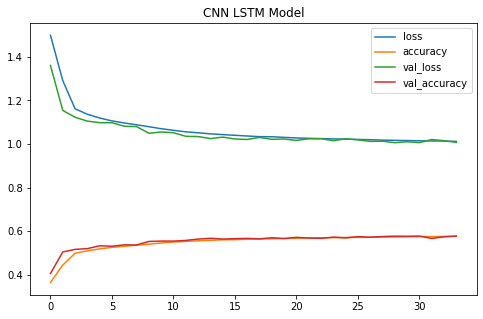

Accuracy at SNR = -20 is 0.10405555555555555%


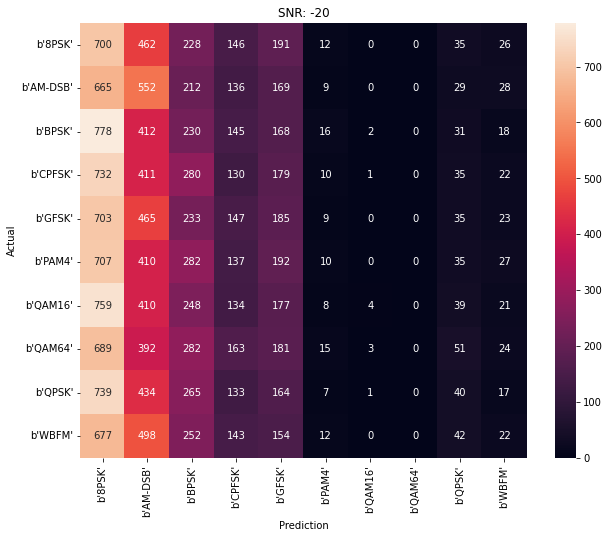

Accuracy at SNR = -18 is 0.11438888888888889%


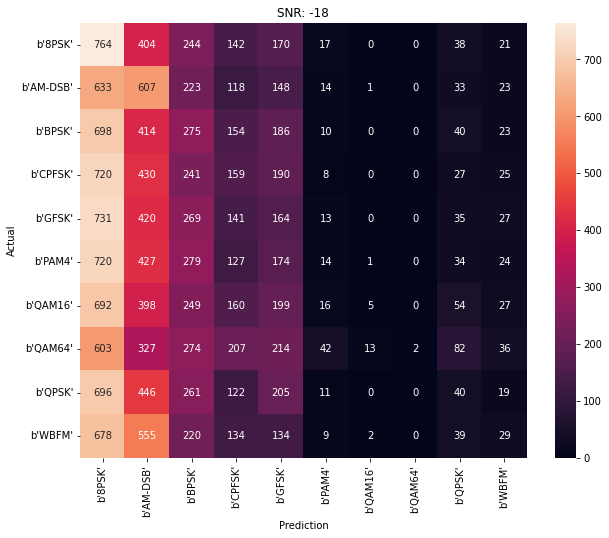

Accuracy at SNR = -16 is 0.11966666666666667%


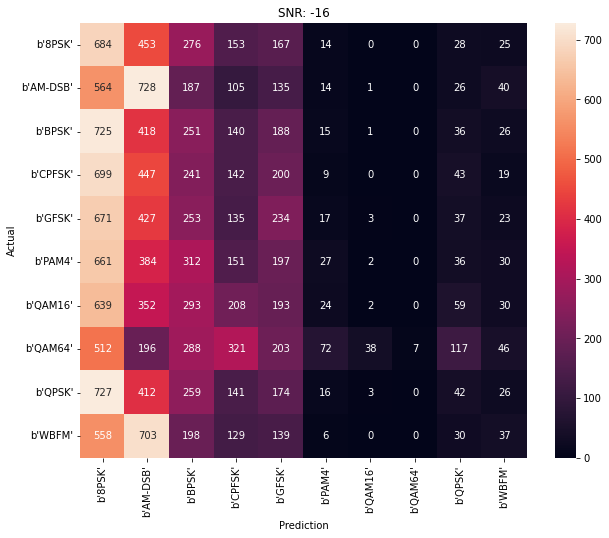

Accuracy at SNR = -14 is 0.1408888888888889%


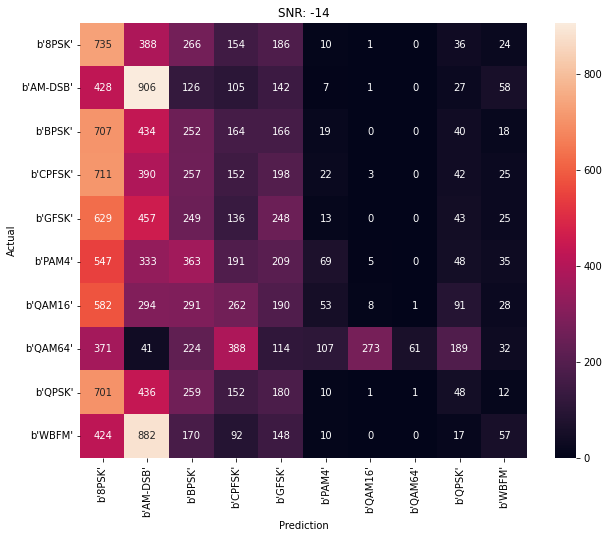

Accuracy at SNR = -12 is 0.18388888888888888%


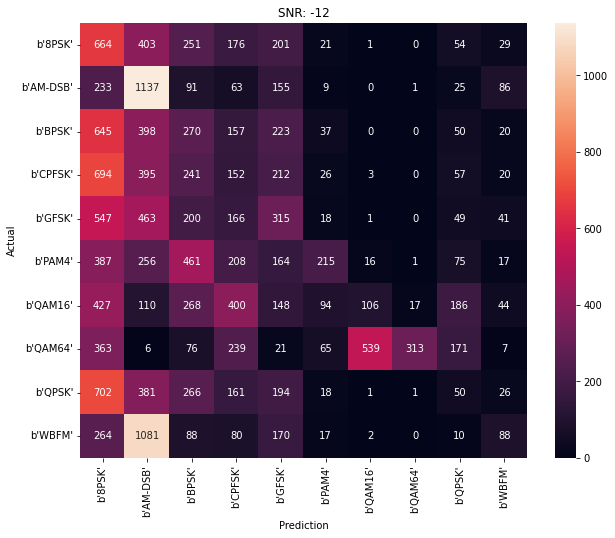

Accuracy at SNR = -10 is 0.2801111111111111%


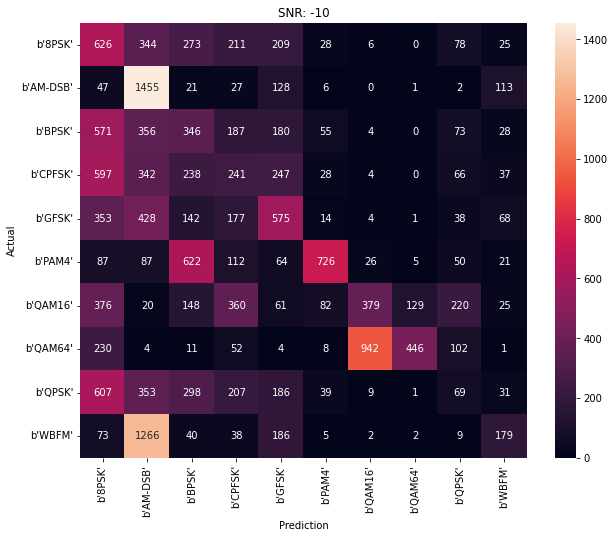

Accuracy at SNR = -8 is 0.3595555555555556%


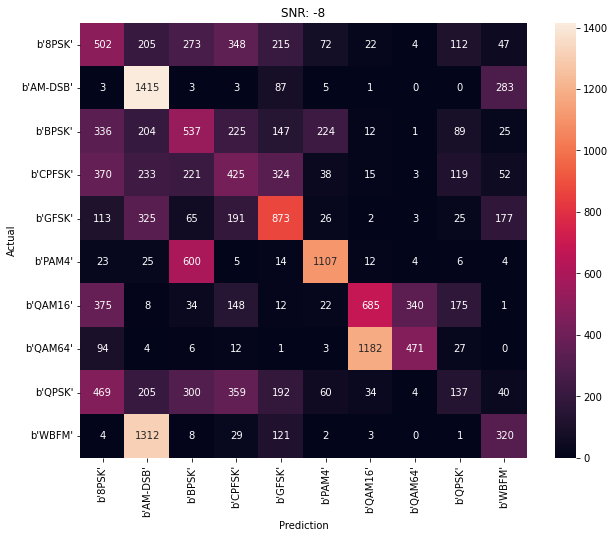

Accuracy at SNR = -6 is 0.4832222222222222%


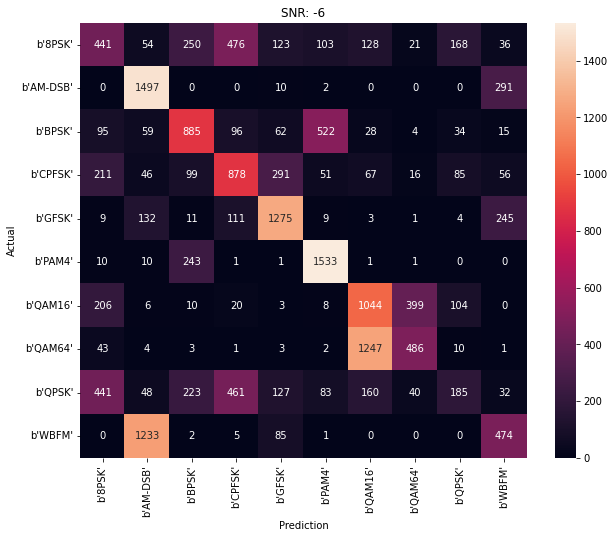

Accuracy at SNR = -4 is 0.6195%


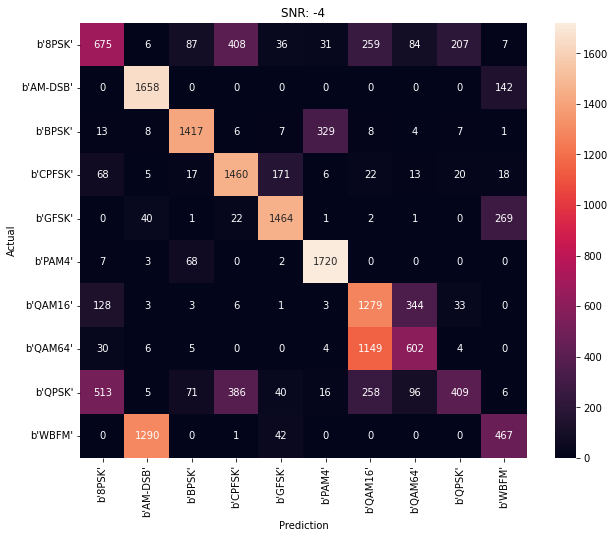

Accuracy at SNR = -2 is 0.7317222222222223%


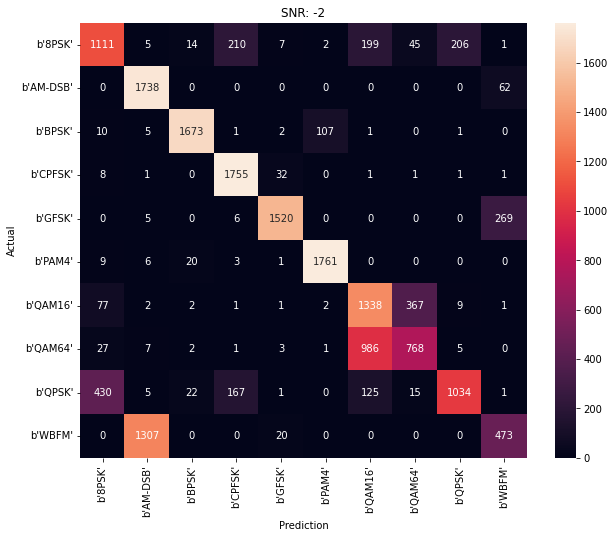

Accuracy at SNR = 0 is 0.7948333333333333%


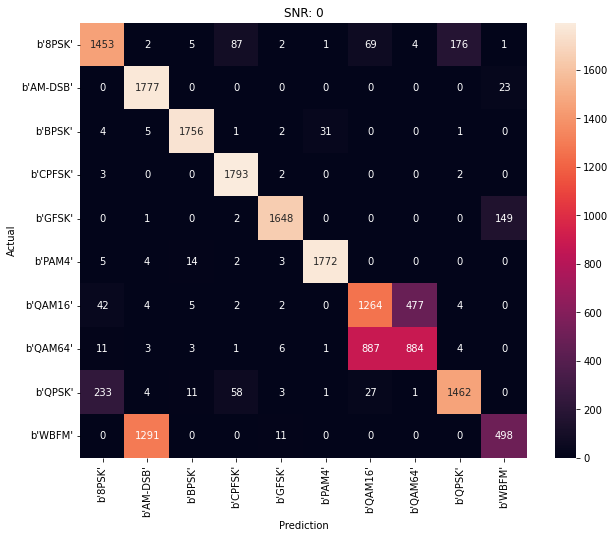

Accuracy at SNR = 2 is 0.8238333333333333%


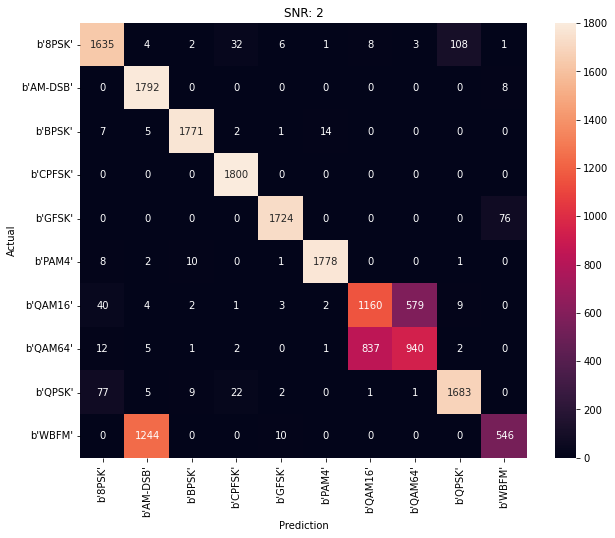

Accuracy at SNR = 4 is 0.8381111111111111%


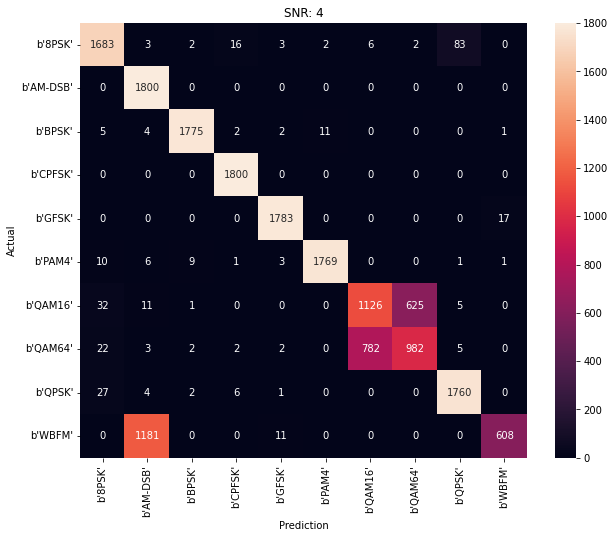

Accuracy at SNR = 6 is 0.839%


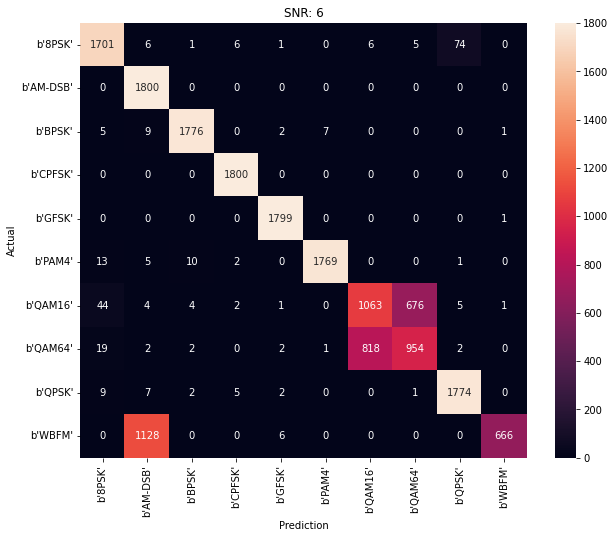

Accuracy at SNR = 8 is 0.8478888888888889%


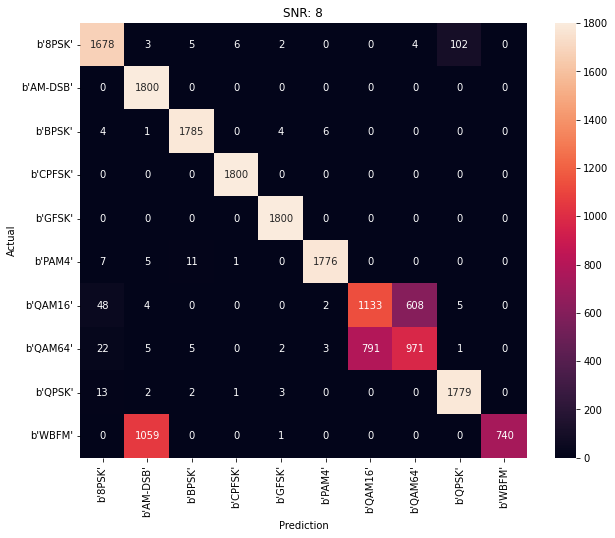

Accuracy at SNR = 10 is 0.846%


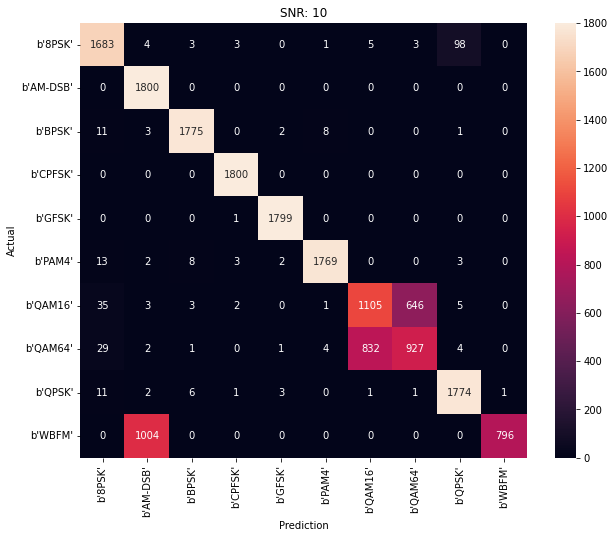

Accuracy at SNR = 12 is 0.8427222222222223%


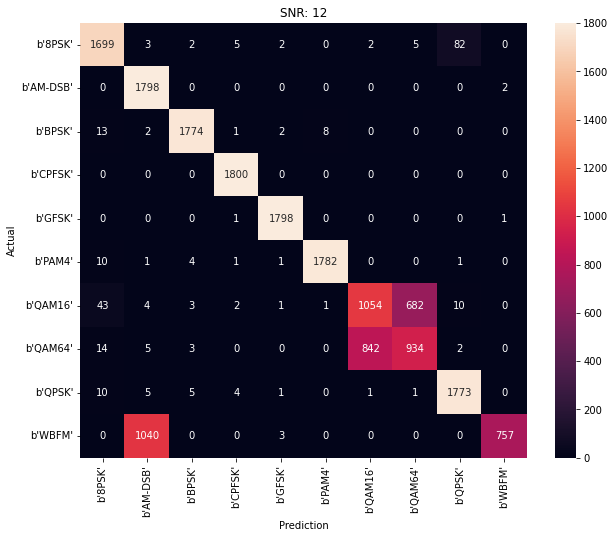

Accuracy at SNR = 14 is 0.8497222222222223%


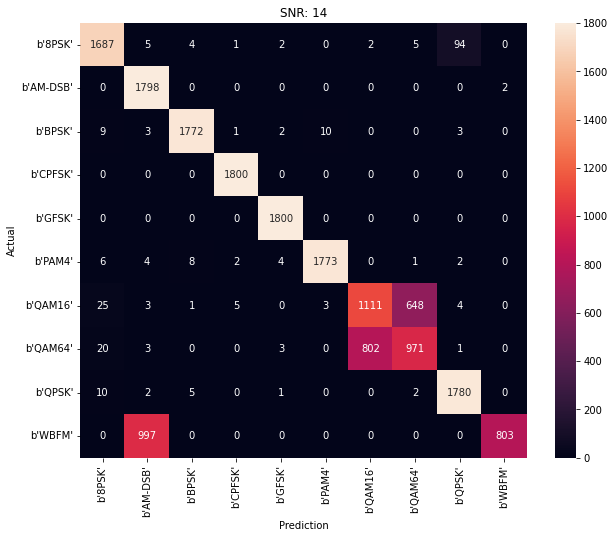

Accuracy at SNR = 16 is 0.8502777777777778%


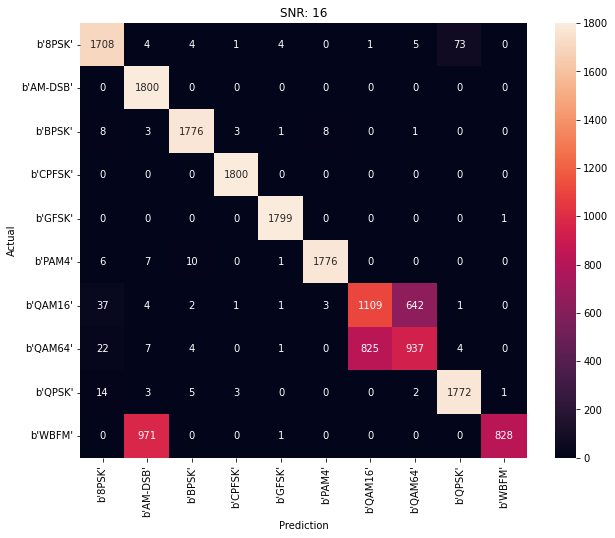

Accuracy at SNR = 18 is 0.852%


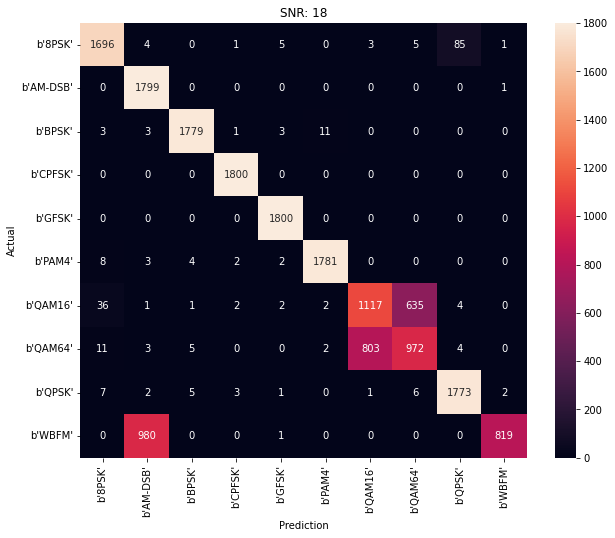

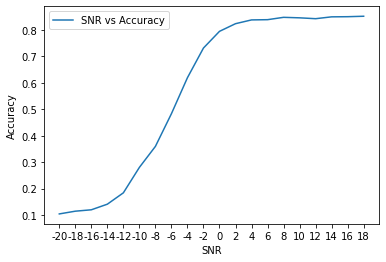

In [53]:
plot_model_history(history, 'CNN LSTM Model')
model_scoring(cnn_lstm_model_2, X_test, testing_pair_labels)  